In [1]:
from transformers import LayoutLMv3Tokenizer,LayoutLMv3FeatureExtractor,LayoutLMv3ForTokenClassification,AutoModelForTokenClassification,AutoProcessor
import pandas as pd
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from PIL import Image, ImageDraw, Image, ImageFont, ImageColor, ImageOps
from sklearn.utils import shuffle
import random
from torch.utils.tensorboard import SummaryWriter

In [2]:
features = LayoutLMv3FeatureExtractor()
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [3]:
company = [163,92,1627,166]
job = [250,163,1627,221]
ssn =[174,226,1627,292]
resident = [266, 295, 1627, 355]
location = [353,361,1627,420]
blood_group = [298,421,1627,495]
website = [226,495,1627,564]
username = [255, 561,1627, 617]
name = [189, 619, 1627, 685]
sex = [158, 690, 1627, 762]
address = [224, 762, 1627,830]
mail = [179, 833, 1627, 888]
birthday = [234, 893, 1627, 967]
description = [68, 1062, 1627,2307]

annotation_dict = {
    'job':job,
    'company':company,
    'ssn':ssn,
    'resident':resident,
    'location': location,
    'blood_group': blood_group,
    'website':website,
    'username':username,
    'name':name,
    'sex':sex,
    'address': address,
    'mail':mail,
    'birthday':birthday,
    'description':description
}

In [6]:
def generateonefakeppdf():
    from faker import Faker
    import warnings
    warnings.filterwarnings('ignore')
    from fpdf import FPDF
    import pdf2image
    fake = Faker()
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('helvetica', size=12)
    profile = fake.profile()
    profile.keys()
    for k in profile.keys():
        try:
            pdf.cell(txt=' ',ln=1)
            pdf.cell(txt=f'{k.capitalize()}:')
            pdf.cell(txt= f' {profile[k]}',ln=1)
        except:
            pass
    pdf.cell(txt=' ',ln=1)
    pdf.cell(0, 10, 'Description', 0, 0, 'C')
    pdf.ln(10)
    pdf.cell(txt=' ',ln=1)
    pdf.cell(txt= fake.catch_phrase(),ln=1)
    pdf.cell(txt=' ',ln=1)
    for p in fake.paragraphs():
        pdf.multi_cell(align='l',txt=p,w=200,ln=1)
        pdf.cell(txt=' ',ln=1)

    pdf.output(f"fakepdf.pdf")
    image = pdf2image.convert_from_path('fakepdf.pdf')[0]
    return image 

In [7]:
def automatefakelabelling(label,words,boxes,hh,ww):
    X1,Y1,X2,Y2 = annotation_dict[label]
    W =[]
    B = []
    for w,b in zip(words,boxes):
        b_ = unnormalize_box(b,ww,hh)
        b_ = [int(a) for a in b_]
        x1,y1,x2,y2 = b_
        xx1 = min(X1, X2) - x1
        xx2 = max(X1, X2) - x2
        yy1 = min(Y1, Y2) - y1
        yy2 = max(Y1, Y2) - y2
        if xx1 <= 0 and yy1 <= 0 and xx2 >= 0 and yy2 >= 0:
            W.append(w)
            B.append(b)
    return W,B
        

In [8]:
labels = annotation_dict.keys()
label2dict = {}
dict2label = {}
for label, n in zip(labels, [i for i in range(len(labels))]):
    label2dict[label] = n
    dict2label[n] = label
    
dict2label[len(labels)] = 'other'
label2dict['other'] = len(labels)
def generatefakeimageandannotation(image):
    encoding = features(image, return_tensors="pt")
    words = encoding['words'][0]
    boxes = encoding['boxes'][0]
    hh,ww = image.height,image.width
    W =[]
    B =[]
    L = []
    for k in annotation_dict.keys():
        w_,b_= automatefakelabelling(k,words,boxes,hh,ww)
        W.append(w_)
        B.append(b_)
        for k_ in [k for _ in range(len(w_))]:
            L.append(k)

    W_ = []
    B_ = []
    for w,b in zip(W,B):
        for ww,bb in zip(w,b):
            W_.append(ww)
            B_.append(bb)
    
    L = [label2dict[l] for l in L] 
    others = set(words).difference(set(W_))
    for o in others:
        for word,box in zip(words,boxes):
            if o == word:
                W_.append(o)
                B_.append(box)
                L.append(len(labels))
    return W_,B_,L,image

In [100]:
model = AutoModelForTokenClassification.from_pretrained("microsoft/layoutlmv3-large", num_labels=len(label2dict))
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-large", apply_ocr=False)
tokenizer = LayoutLMv3Tokenizer.from_pretrained("microsoft/layoutlmv3-large")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 171)
      (y_position_embeddings): Embedding(1024, 171)
      (h_position_embeddings): Embedding(1024, 170)
      (w_position_embeddings): Embedding(1024, 170)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3

In [57]:
def generateencoder():
    image = generateonefakeppdf()
    a,b,c,d = generatefakeimageandannotation(image)
    n_ = [i for i in range(len(a))]
    n_ = shuffle(n_)
    A = []
    B = []
    C = []
    for n in n_:
        A.append(a[n])
        B.append(b[n])
        C.append(c[n])
    print(C)
    encoding = processor(d, A,boxes=B,word_labels=C, return_tensors="pt",padding=True, truncation=True)
    return encoding.to(device)

In [11]:
Encodes = []
for i in range(500):
    encoding = generateencoder()
    if i % 50 == 0:
        print(i)
    Encodes.append(encoding)

0
50
100
150
200
250
300
350
400
450


In [76]:
Encodes = shuffle(Encodes)
train_data = Encodes[:int(len(Encodes)*0.8)]
val_data = Encodes[:int(len(Encodes)*0.2)]

In [13]:
writer = SummaryWriter()

In [101]:
optimiser = AdamW(model.parameters(), lr=6e-5)
scheduler = StepLR(optimiser, step_size=1, gamma=0.97)

In [102]:
total_loss = 0
n = 1
model.train()
for epoch in range(1):
    for encoding in train_data:
        if n != 0:
            scheduler.step()
        outputs = model(**encoding)
        loss = outputs.loss
        writer.add_scalar('Loss/train',loss.item(),n)
        writer.add_scalar('LearningRate/train',scheduler.get_last_lr()[0],n)
        scheduler.optimizer.zero_grad()
        loss.backward()
        scheduler.optimizer.step()
        n += 1
writer.close()

Need at least 100 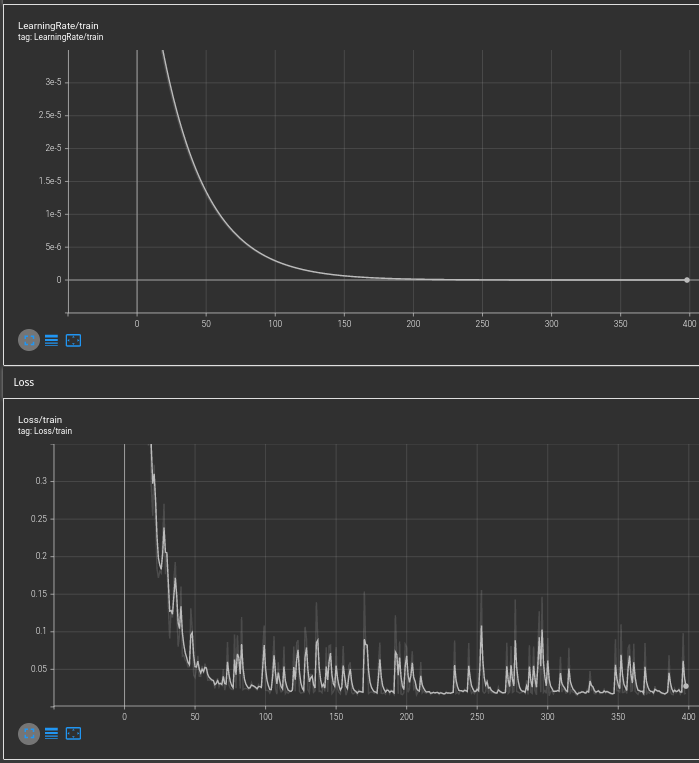

In [103]:
%%capture
model.eval()

In [115]:
Accuracy = []
for encoding in val_data:
    with torch.no_grad():
        outputs = model(**encoding)
        predicted_labels = outputs.logits.argmax(-1).tolist()[0]
        true_labels = encoding['labels'][0]
        total = 0
        total_accurate = 0
        for x,y in zip(predicted_labels,true_labels):
            y = y.item()
            if y != -100:
                total += 1
                if x == y:
                    total_accurate += 1
        accuracy = float(total_accurate/total)
        Accuracy.append(accuracy)    
Accuracy = round(100*sum(Accuracy)/len(Accuracy),2)
Accuracy = f'{Accuracy} %'    
print(Accuracy)

99.8 %


In [116]:
model.save_pretrained('/home/delta/vscode/dataextraction/model')

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('/home/delta/vscode/dataextraction/model')
model.to(device)
model.eval()

In [158]:
def getBoundingBox(X):
    if type(X[0][0]) != list:
        X = [X]
    XX = []
    for ss in X:
        s1 = []
        s2 = []
        s3 = []
        s4 = []
        for s in ss:
            s1.append(int(s[0]))
            s2.append(int(s[1]))
            s3.append(int(s[2]))
            s4.append(int(s[3]))
        x1 = min(s1)-5
        y1 = min(s2)-5
        x2 = max(s3)+5
        y2 = max(s4)+5
        XX.append([x1,y1,x2,y2])
    return XX
def extractData(image):
    encoding = features(image)
    encoding = processor(image, encoding['words'],boxes=encoding['boxes'], return_tensors='pt')
    outputs = model(**encoding.to(device))
    outputs = [dict2label[s] for s in outputs.logits.argmax(-1).tolist()[0]]
    inputs = encoding['input_ids'][0]
    boxes = encoding['bbox'].cpu().tolist()[0]
    inputs = [processor.decode(i) for i in inputs]
    da = pd.DataFrame(columns=['inputs','outputs','boxes'])
    da['inputs'] = inputs
    da['outputs'] = outputs
    da['boxes'] = boxes
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    answer = pd.DataFrame(columns=['key','value'])
    l = 0
    for n,g in da.groupby('outputs'):
        if n == 'other':
            continue
        pre = g['inputs'].values.tolist()
        pre = ''.join(pre)
        pre = pre.lstrip().rstrip()
        n = n.capitalize()
        answer.at[l,'key'] = n
        answer.at[l,'value'] = pre
        l += 1
        box = g['boxes'].values.tolist()
        color = tuple(random.choices(range(256), k=3))  
        for b in box:
            x1,y1,x2,y2 = b
            x1 = int(image.width*x1/1000)
            x2 = int(image.width*x2/1000)
            y1 = int(image.height*y1/1000)
            y2 = int(image.height*y2/1000)
            b = [x1,y1,x2,y2]
            draw.rectangle(b, outline=color, width=2)
            draw.text((b[0] + 10, b[1] - 10), n, fill='red', font=font)
    return answer, image
def generateonefakeppdf():
    from faker import Faker
    import warnings
    warnings.filterwarnings('ignore')
    from fpdf import FPDF
    import pdf2image
    fake = Faker()
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('helvetica', size=12)
    profile = fake.profile()
    profile.keys()
    for k in profile.keys():
        try:
            pdf.cell(txt=' ',ln=1)
            pdf.cell(txt=f'{k.capitalize()}:')
            pdf.cell(txt= f' {profile[k]}',ln=1)
        except:
            pass
    pdf.cell(txt=' ',ln=1)
    pdf.cell(0, 10, 'Description', 0, 0, 'C')
    pdf.ln(10)
    pdf.cell(txt=' ',ln=1)
    pdf.cell(txt= fake.catch_phrase(),ln=1)
    pdf.cell(txt=' ',ln=1)
    for p in fake.paragraphs():
        pdf.multi_cell(align='l',txt=p,w=200,ln=1)
        pdf.cell(txt=' ',ln=1)

    pdf.output(f"fakepdf.pdf")
    image = pdf2image.convert_from_path('fakepdf.pdf')[0]
    return image      

In [159]:
def generatetest():
    image_ = generateonefakeppdf()
    image = image_.copy()
    e,s =extractData(image_)
    for i,r in e.iterrows():
        
        print('')
        print('')
        key = r['key']
        print(key)
        print('')
        print(r['value'])
        print('____________________________________________________________________________')
    return s



Address

6656785 PSC 9896, Box 9551APO AA 65131
____________________________________________________________________________


Birthday

1972-08-05
____________________________________________________________________________


Blood_group

A-
____________________________________________________________________________


Company

Teaching laboratory technician
____________________________________________________________________________


Description

<s> Down-sized object-oriented installation Serious their direction nearly play. Decision wait energy daughter wide whether. Fall cut office computer say provide. Official account smile last large just cup. Each son travel network more view. Increase ago impact free. According quality song law capital like. Speech could message notice ten.</s>
____________________________________________________________________________


Job

Smith, Cochran and Garciagan-jensenorgstonorntonston-smith
_______________________________________________________

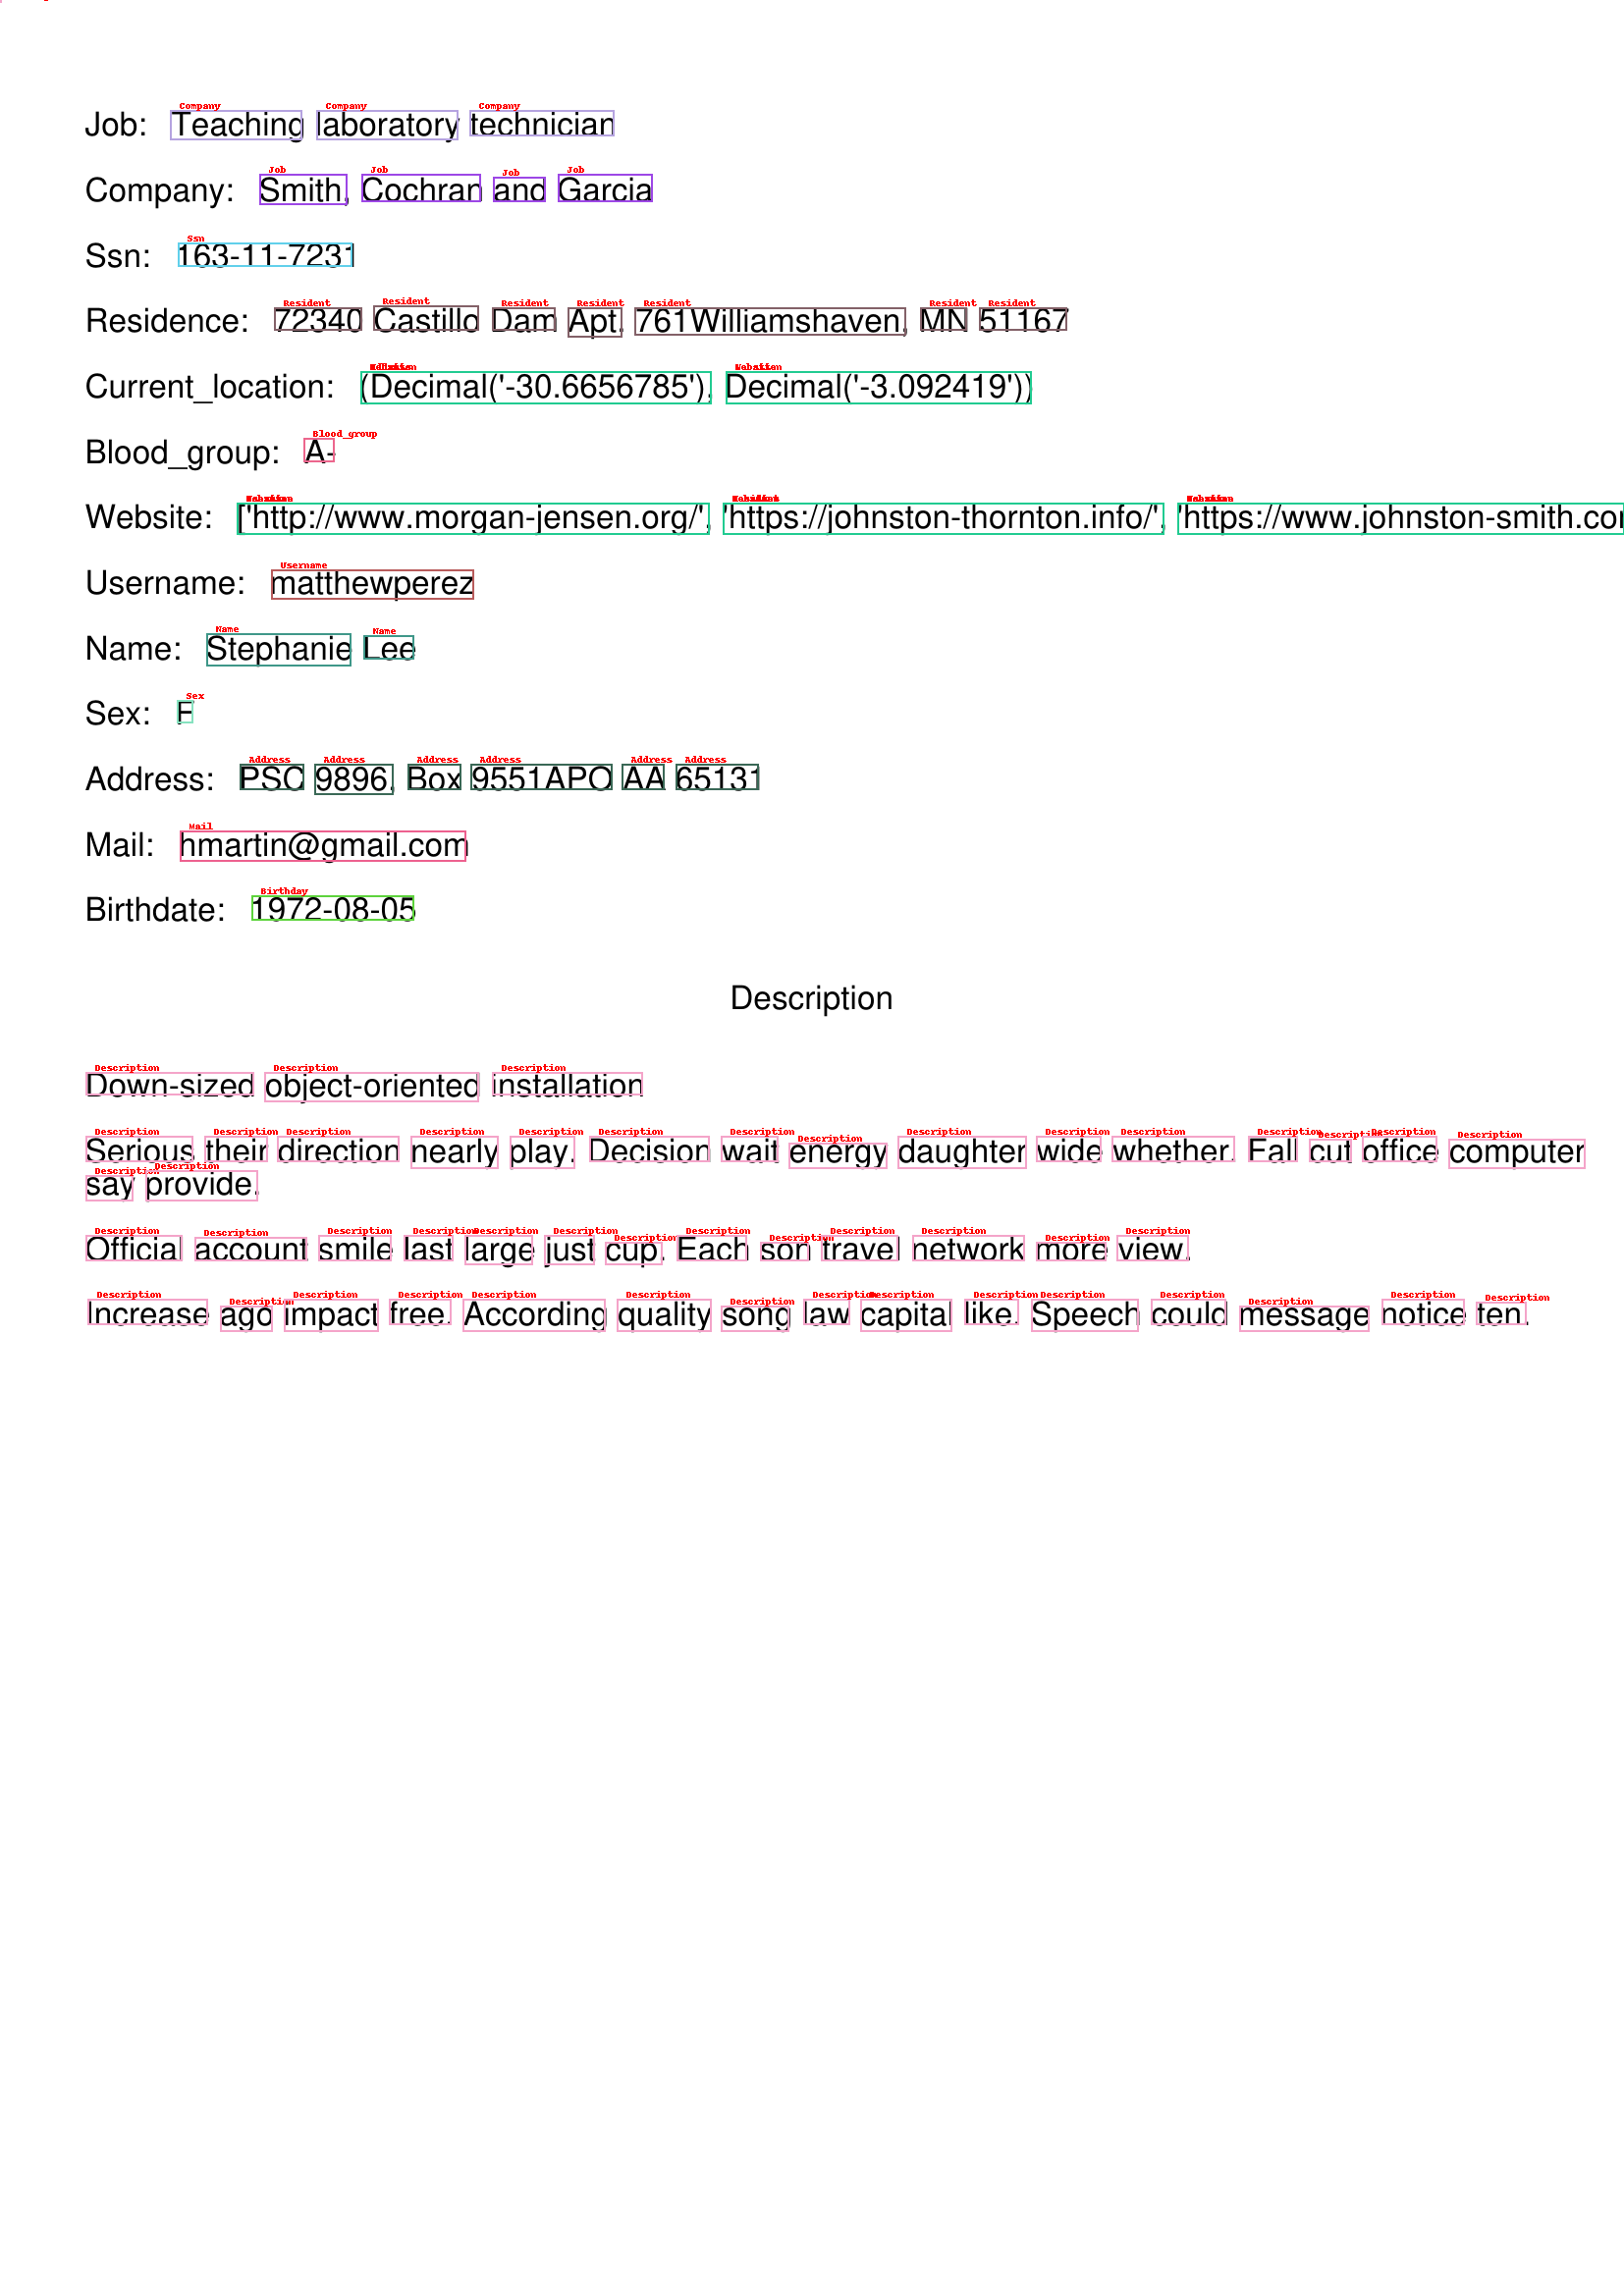

In [160]:
#Test 1
generatetest()



Address

9242 Devon Skyway Apt 745Port Kimberlychester, VT 97729
____________________________________________________________________________


Birthday

1920-09-12
____________________________________________________________________________


Blood_group

O-
____________________________________________________________________________


Company

Personnel officer
____________________________________________________________________________


Description

<s>. Assimilated uniform projection Science second economy believe imagine after. Head program late board statement teacher push. Family present one modern. Less teach product. Worry particular happen out fear throw. Yes trade manager public imagine opportunity treatment.</s>
____________________________________________________________________________


Job

Lewis, Ferguson and Williamsonporter.info/
____________________________________________________________________________


Location

(Decimal-86.0593135 Decimal103.180034))http
___

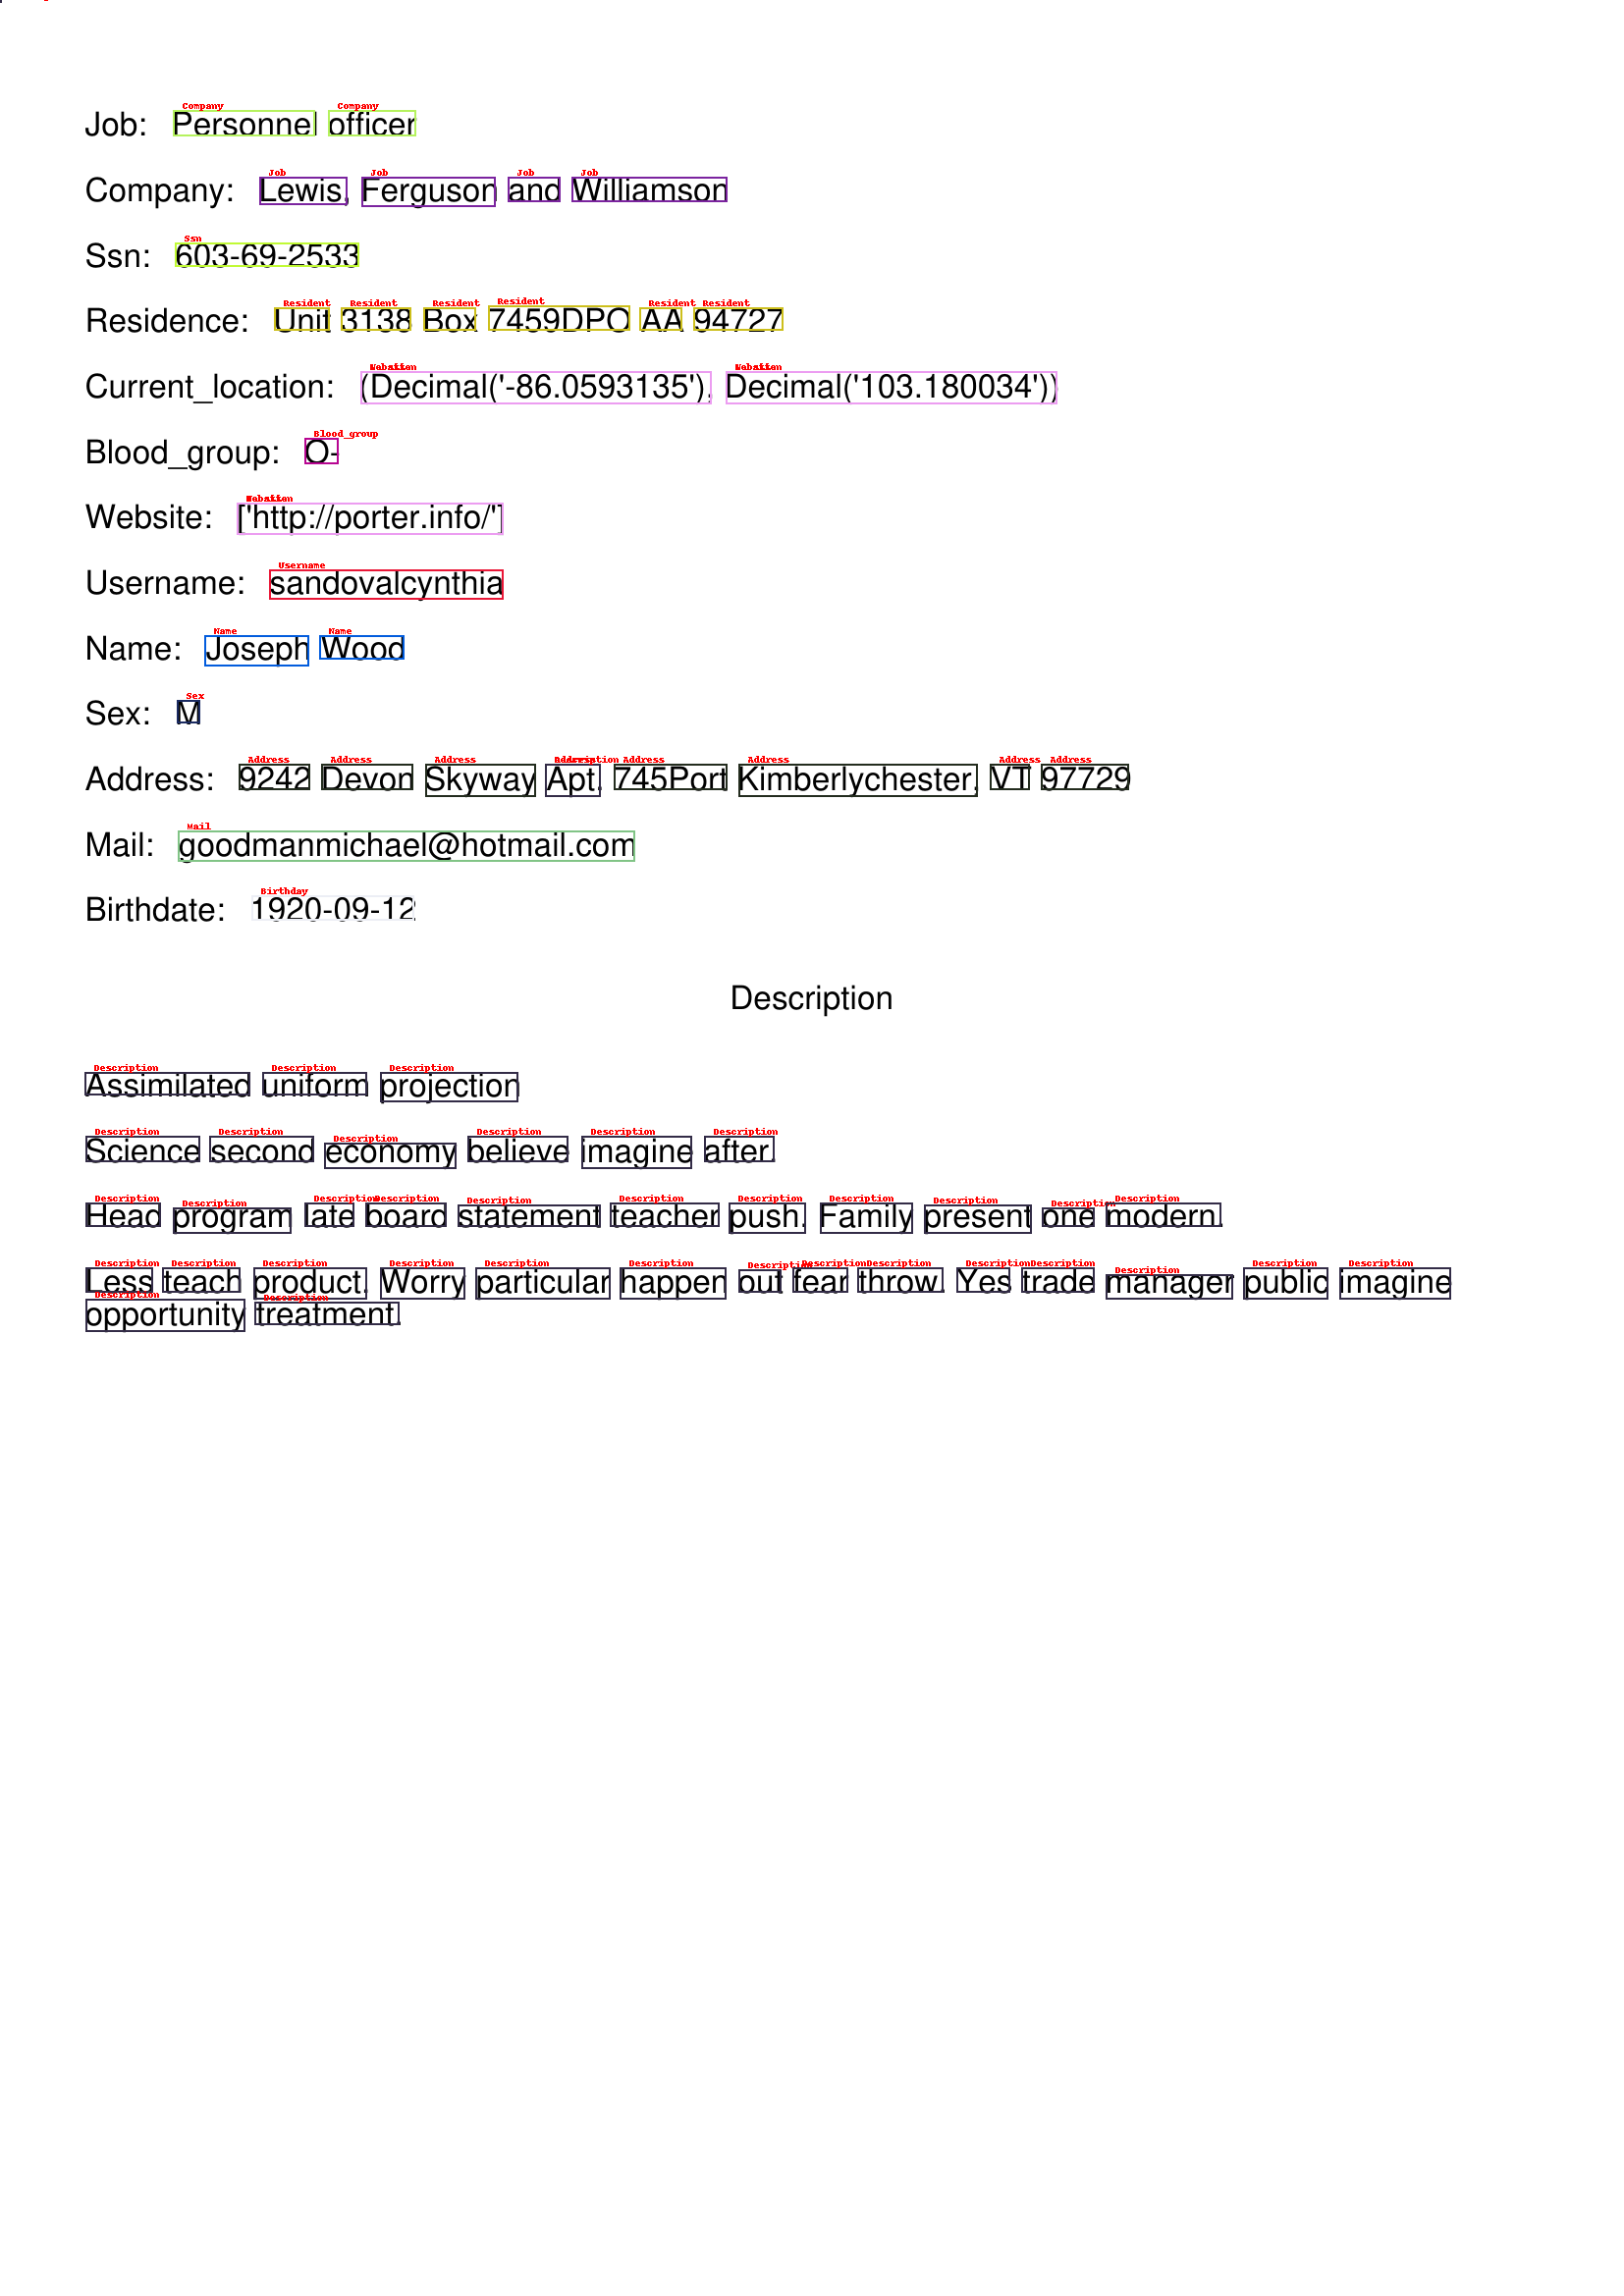

In [161]:
#Test 2
generatetest()



Address

59 73226 Nicholas Ville Suite 916Goodwinville, OH 92758
____________________________________________________________________________


Birthday

2009-01-04
____________________________________________________________________________


Blood_group

A-
____________________________________________________________________________


Company

Accountant, chartered public finance
____________________________________________________________________________


Description

<s> Versatile contextually-based matrix Modern American win finish support stay official. Meet college expect turn study. Though baby yeah notice into campaign. Less operation cell save information run today for. Sure phone level they one some such. Matter Mrs spring sport wall summer. Vote bar the explain.</s>
____________________________________________________________________________


Job

Andrade-Millswalkerbizyoungccormickcom
____________________________________________________________________________


Locati

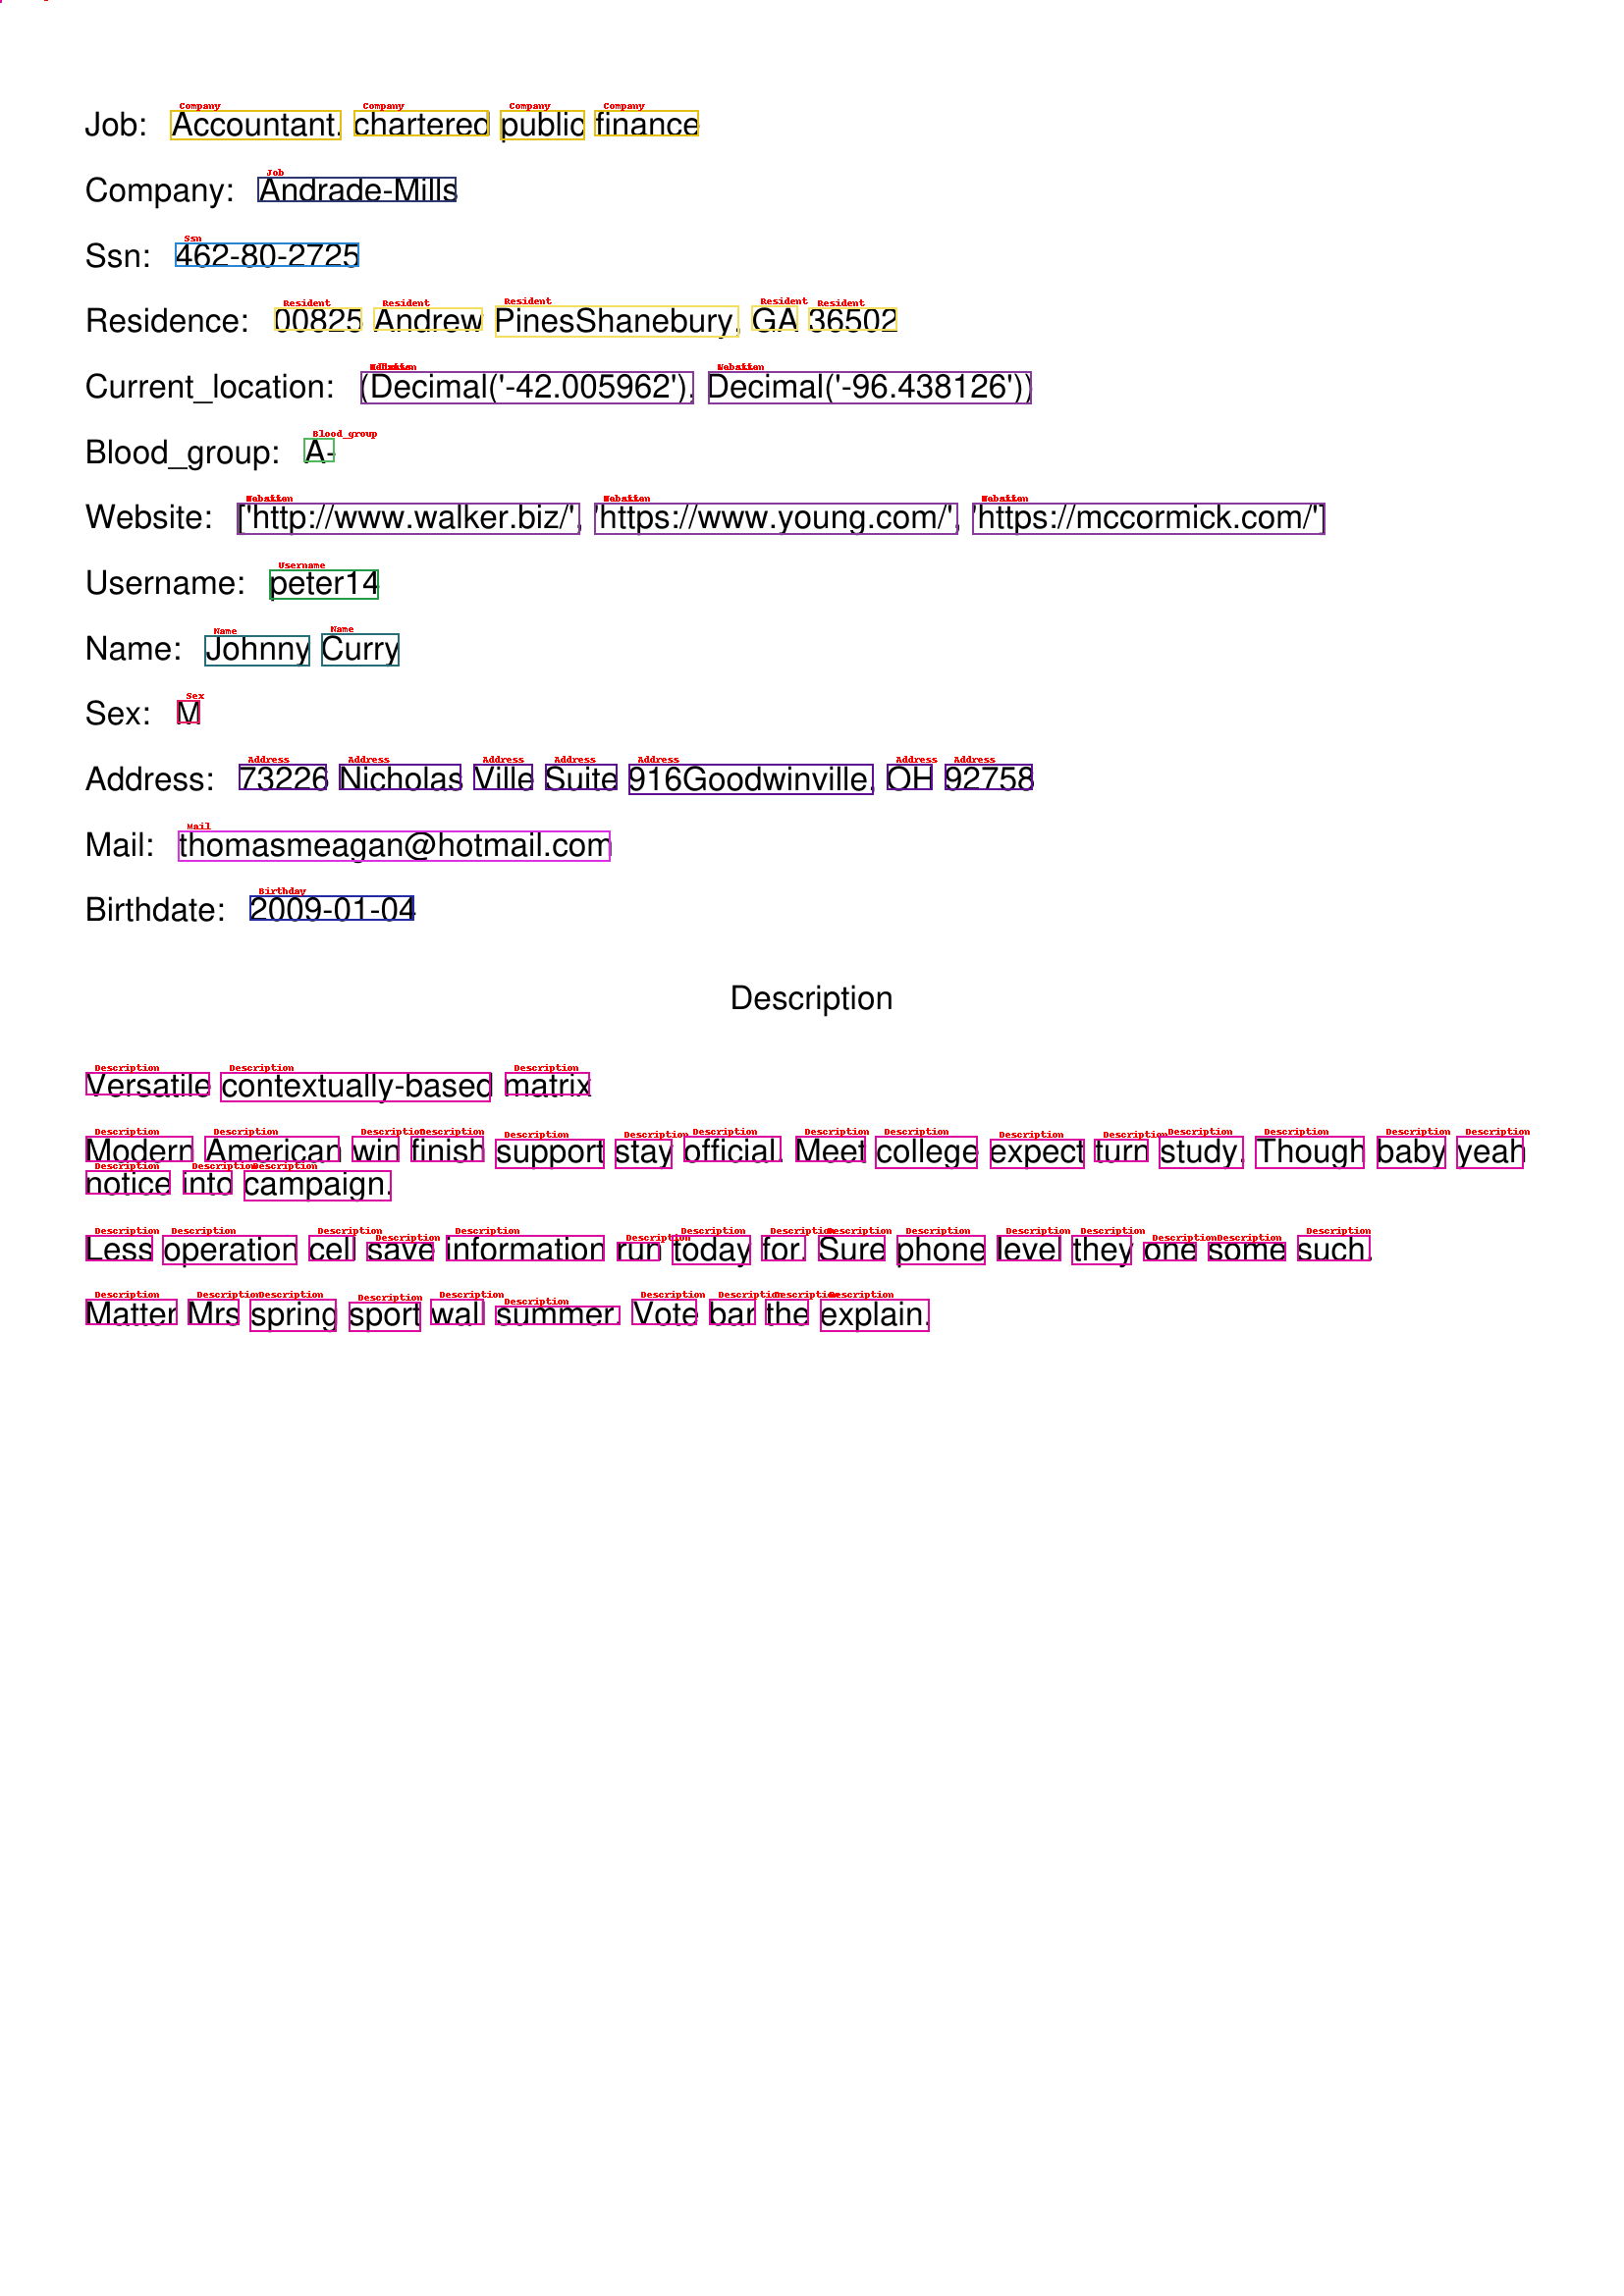

In [162]:
#Test 3
generatetest()



Address

30595595145 Unit 1124 Box 2422DPO AA 90202
____________________________________________________________________________


Birthday

1924-12-04
____________________________________________________________________________


Blood_group

AB-
____________________________________________________________________________


Company

Health visitor
____________________________________________________________________________


Description

<s> Public-key uniform Graphical User Interface Affect prevent fly new. Author early financial finally. Machine today exactly. Continue concern those for. Never figure where financial trip bank. Not others week pass smile grow particular. Last catch social director. Thing never almost Mr here.</s>
____________________________________________________________________________


Job

Adams-Hawkinsonesmitchellorgwestconner
____________________________________________________________________________


Location

(Decimal-51.40 Decimal-132.))http://.com/htt

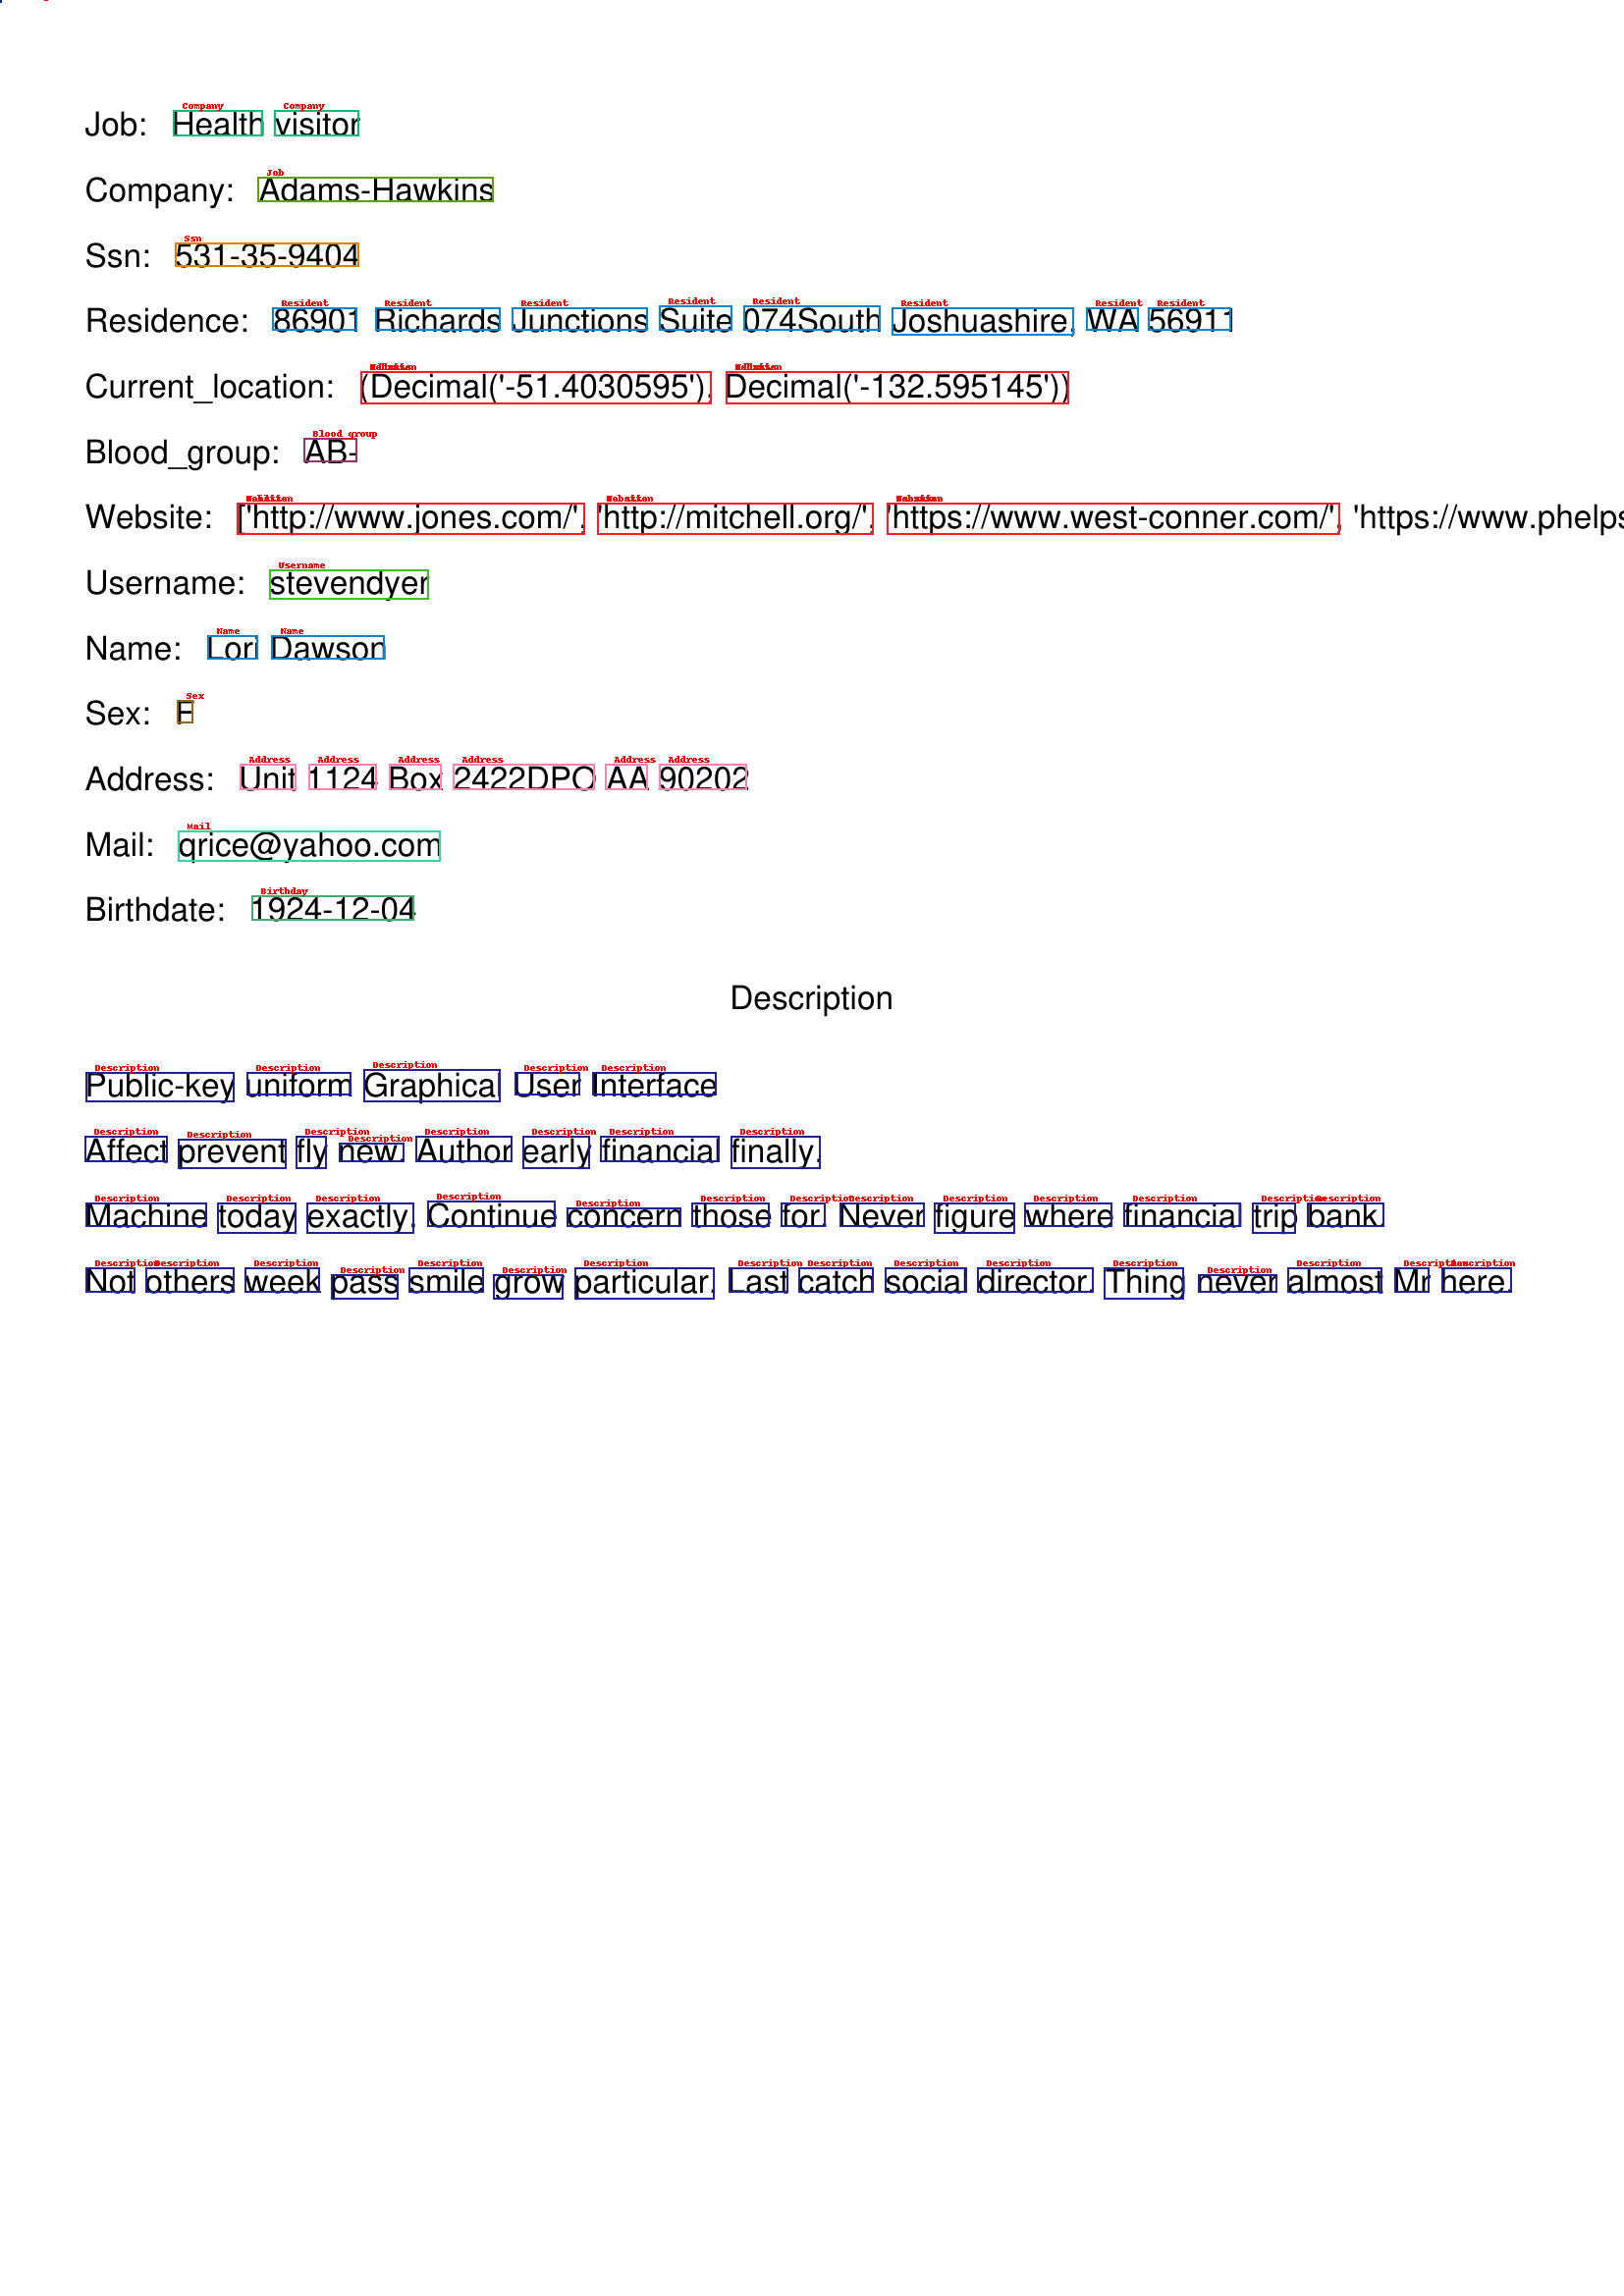

In [163]:
#Test 4
generatetest()



Address

440 82116 Ware Meadow Apt 105Melissaport, DE 98359
____________________________________________________________________________


Birthday

1958-03-12
____________________________________________________________________________


Blood_group

A+
____________________________________________________________________________


Company

Financial adviser
____________________________________________________________________________


Description

<s>. Robust asynchronous support Western really threat cause third. Start toward them nor town address. Wall exactly hair happen away through woman. Surface effect cell within account figure tonight. Picture water force former. Every help until. Still drive after paper.</s>
____________________________________________________________________________


Job

Simmons, Guzman and Rodriguezoldsvelazquezjacksonissiams
____________________________________________________________________________


Location

(Decimal-63.1791035 Decimal65.602))httpA

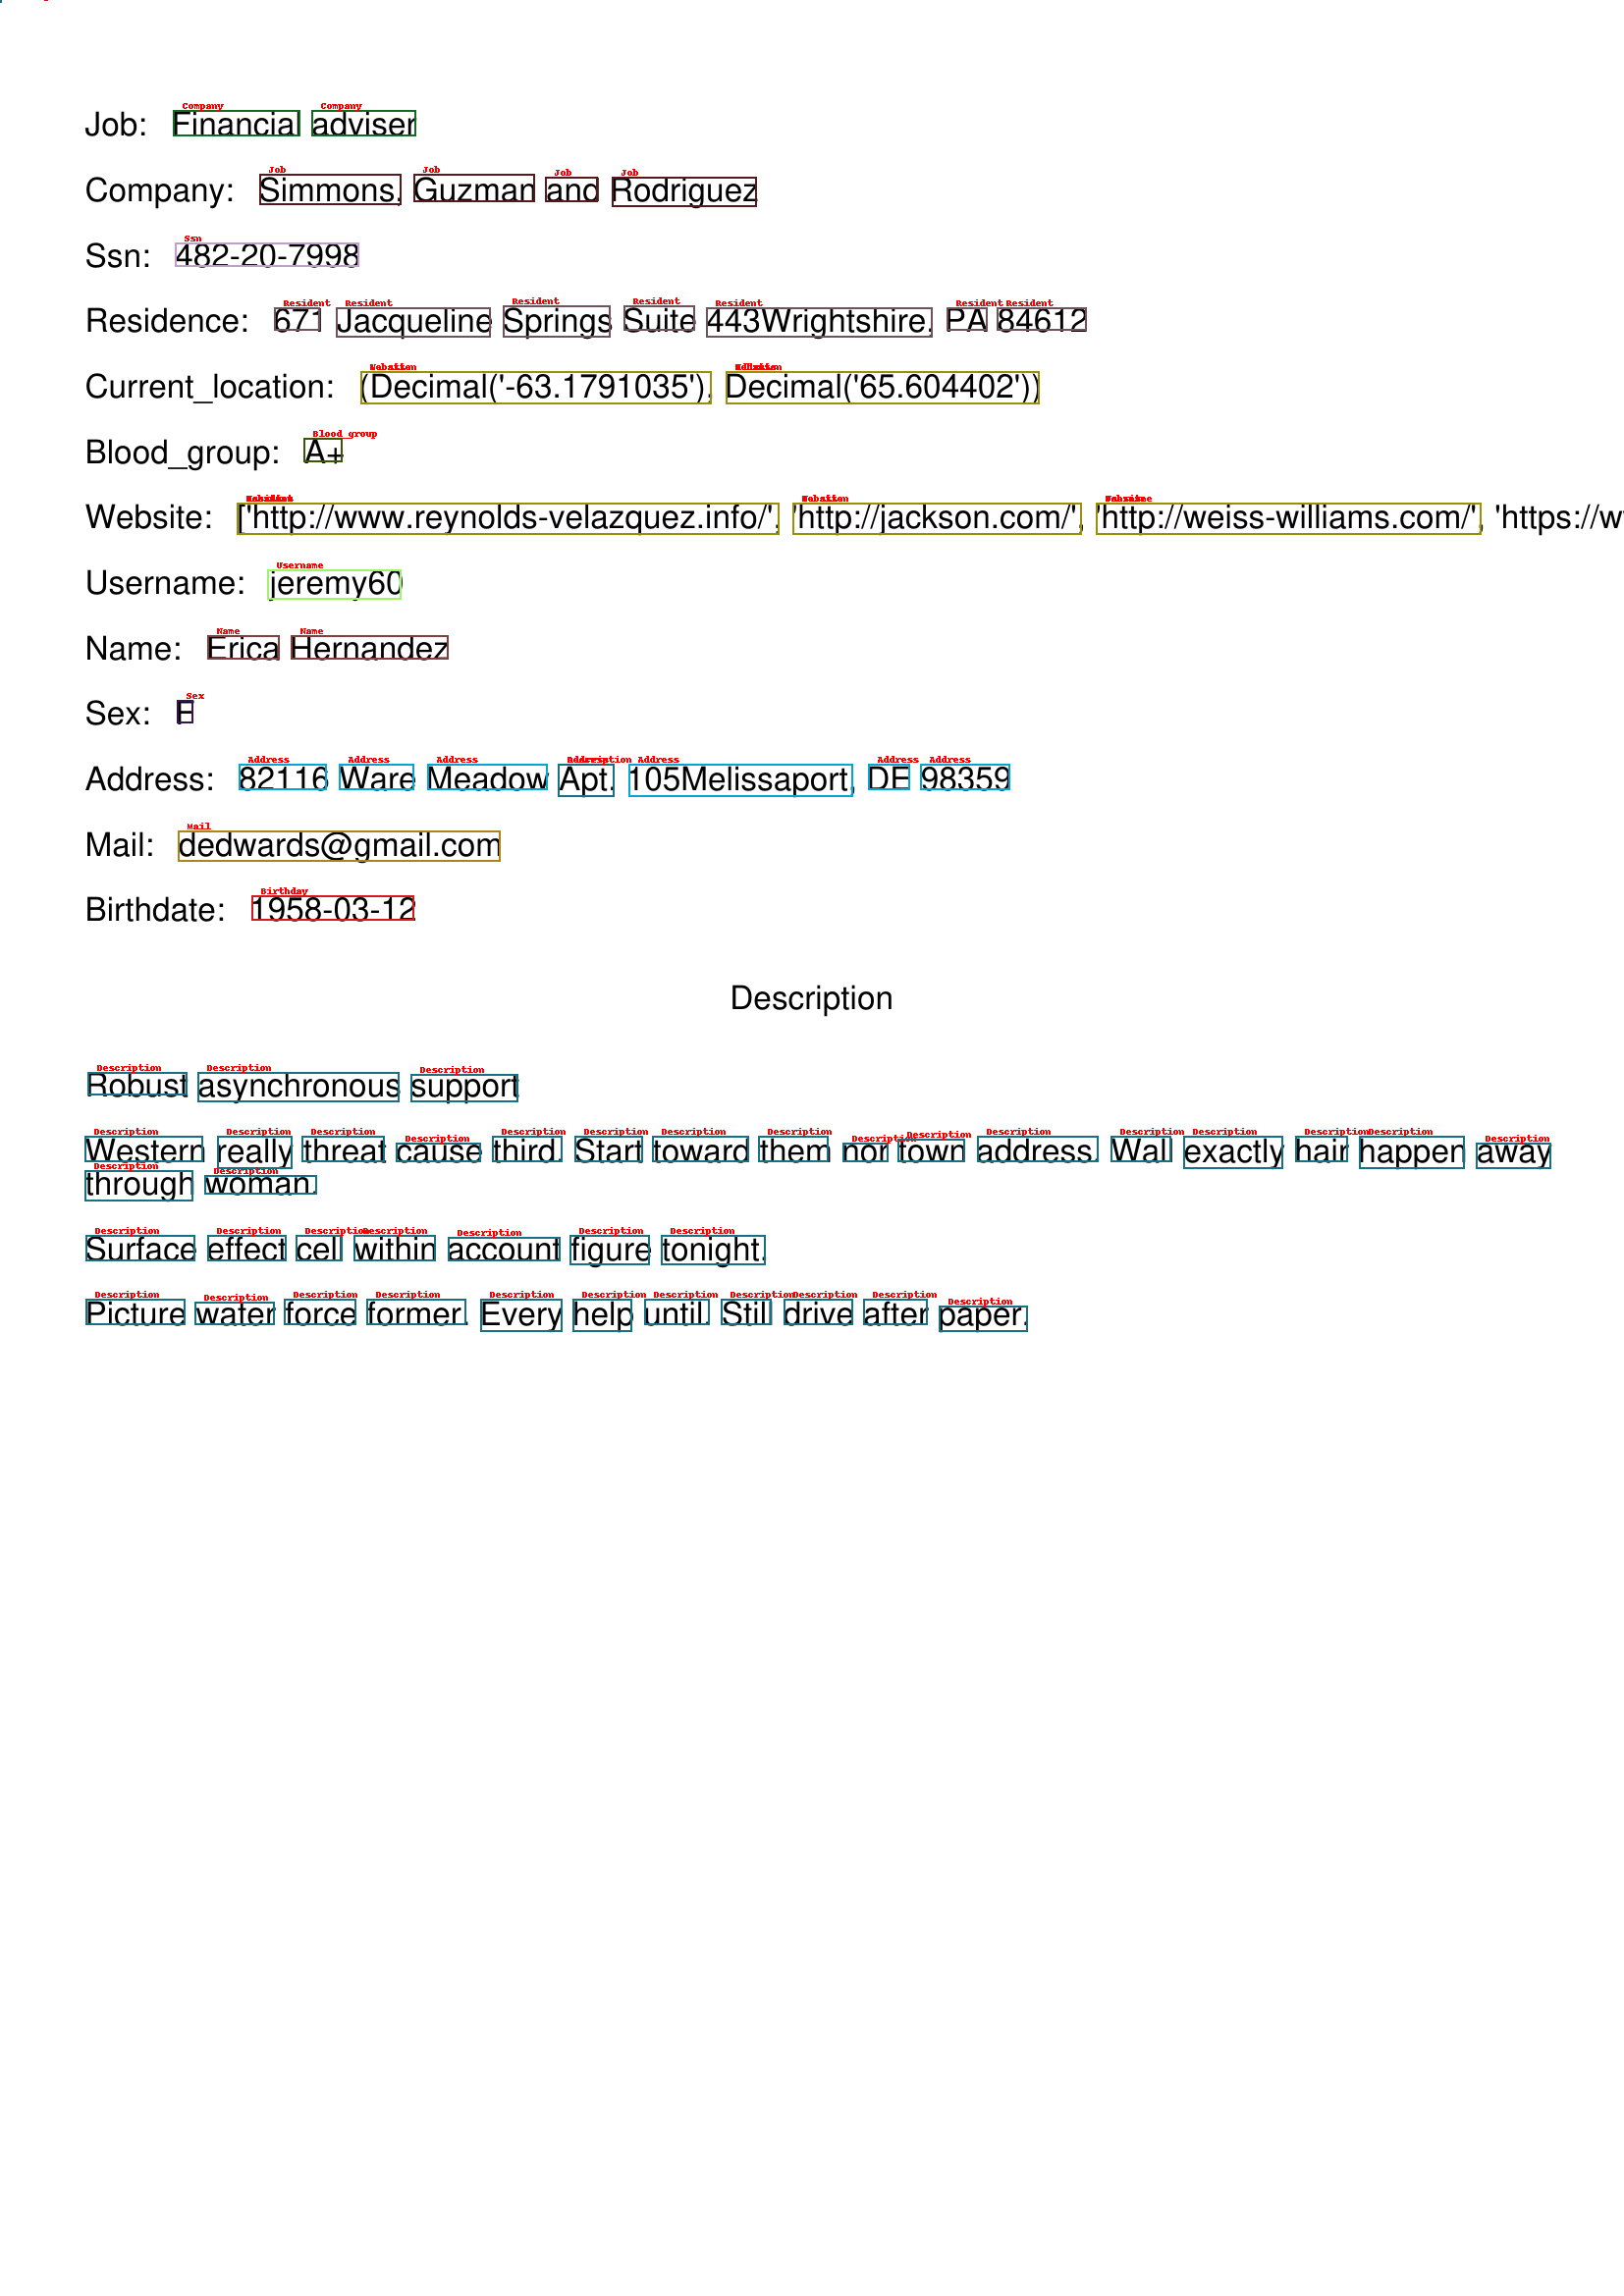

In [164]:
#Test 5
generatetest()



Address

354 Burnett SkywayDavidbury, AL 31886
____________________________________________________________________________


Birthday

2008-04-07
____________________________________________________________________________


Blood_group

AB-
____________________________________________________________________________


Company

Educational psychologist
____________________________________________________________________________


Description

<s> Customizable user-facing capacity Hair old look pass. Old trip group first cover its food. Season news appear of. North choose safe she wall lot plan. Management expect seem student strong. Bed front man.</s>
____________________________________________________________________________


Job

Navarro Groupbiz
____________________________________________________________________________


Location

(Decimal-84.179059 Decimal67.476359))http./
____________________________________________________________________________


Mail

aaronfranklin@hotm

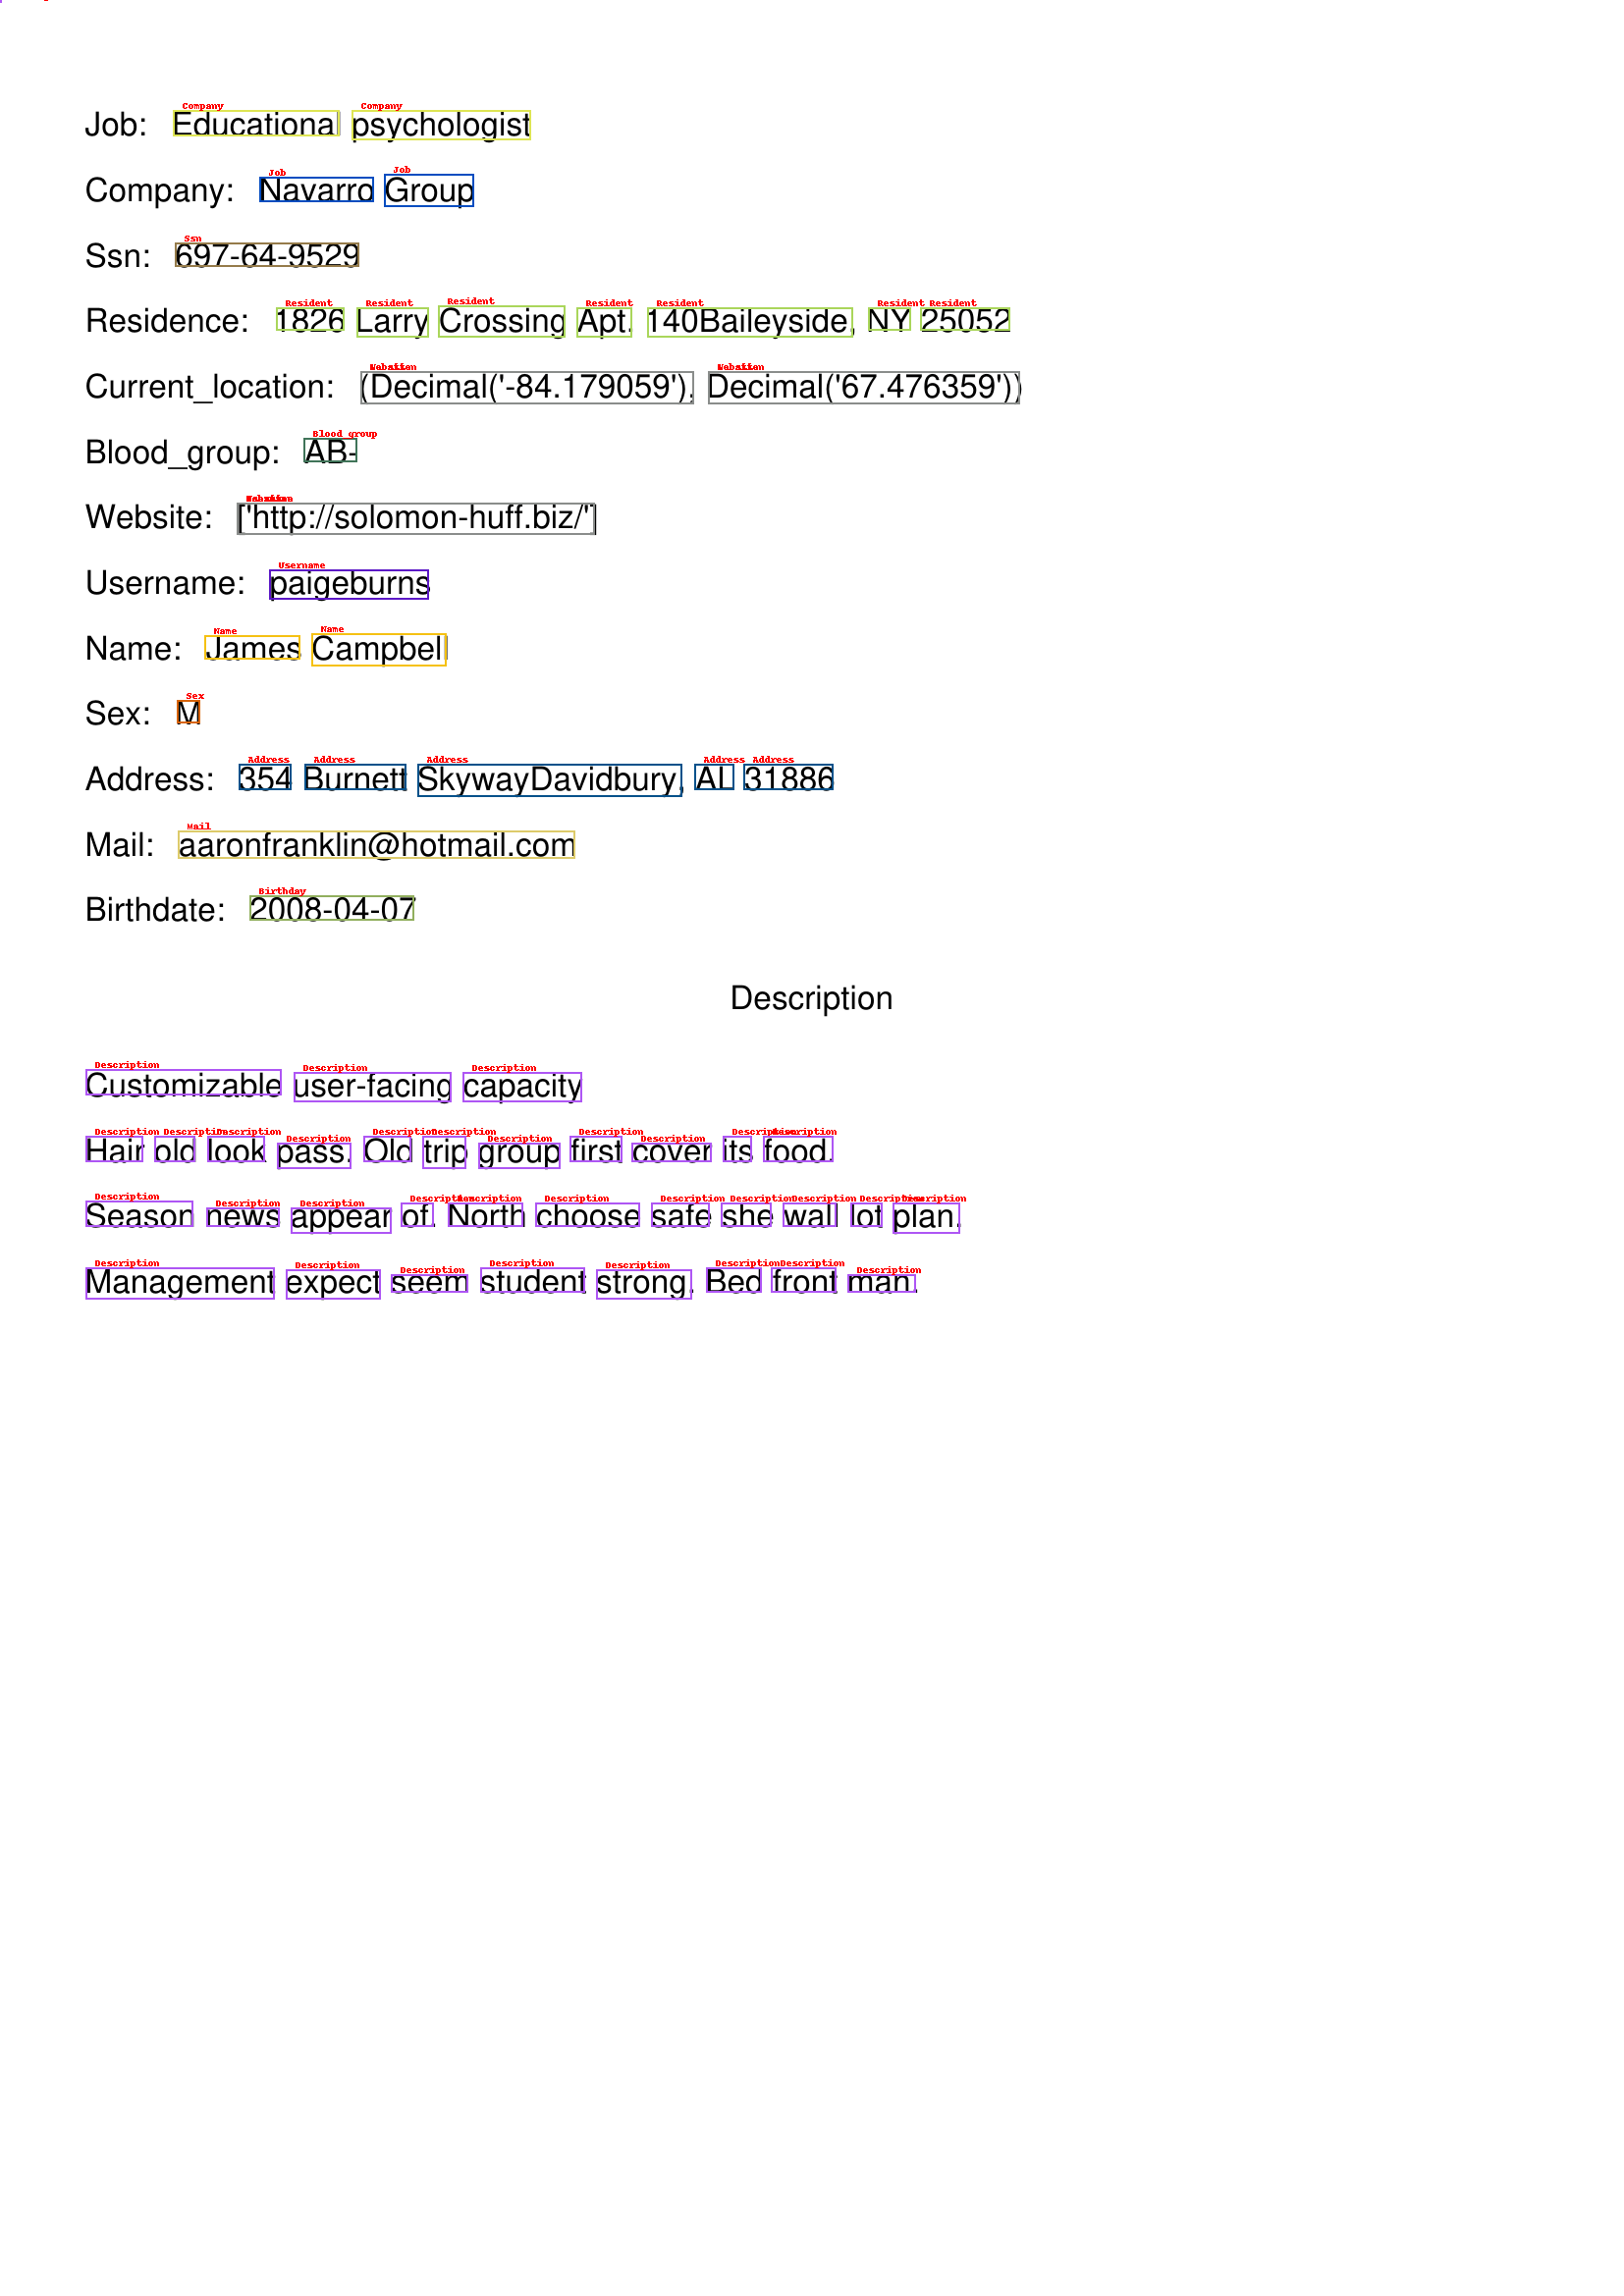

In [165]:
#Test 6
generatetest()



Address

55 697 David Gardens Suite 431Mitchellside, LA 75174
____________________________________________________________________________


Birthday

1924-04-24
____________________________________________________________________________


Blood_group

AB-
____________________________________________________________________________


Company

Clinical research associate
____________________________________________________________________________


Description

<s> Progressive 24/7 moderator Different vote control maintain. Trouble could bad ago travel southern medical. Instead grow yeah executive. Wonder successful no. Information stand compare fight be provide end. Example say general all.</s>
____________________________________________________________________________


Job

Palmer-Knappire
____________________________________________________________________________


Location

(Decimal3.7345 Decimal94.2924))www.mcgu-vincent.net/
___________________________________________________

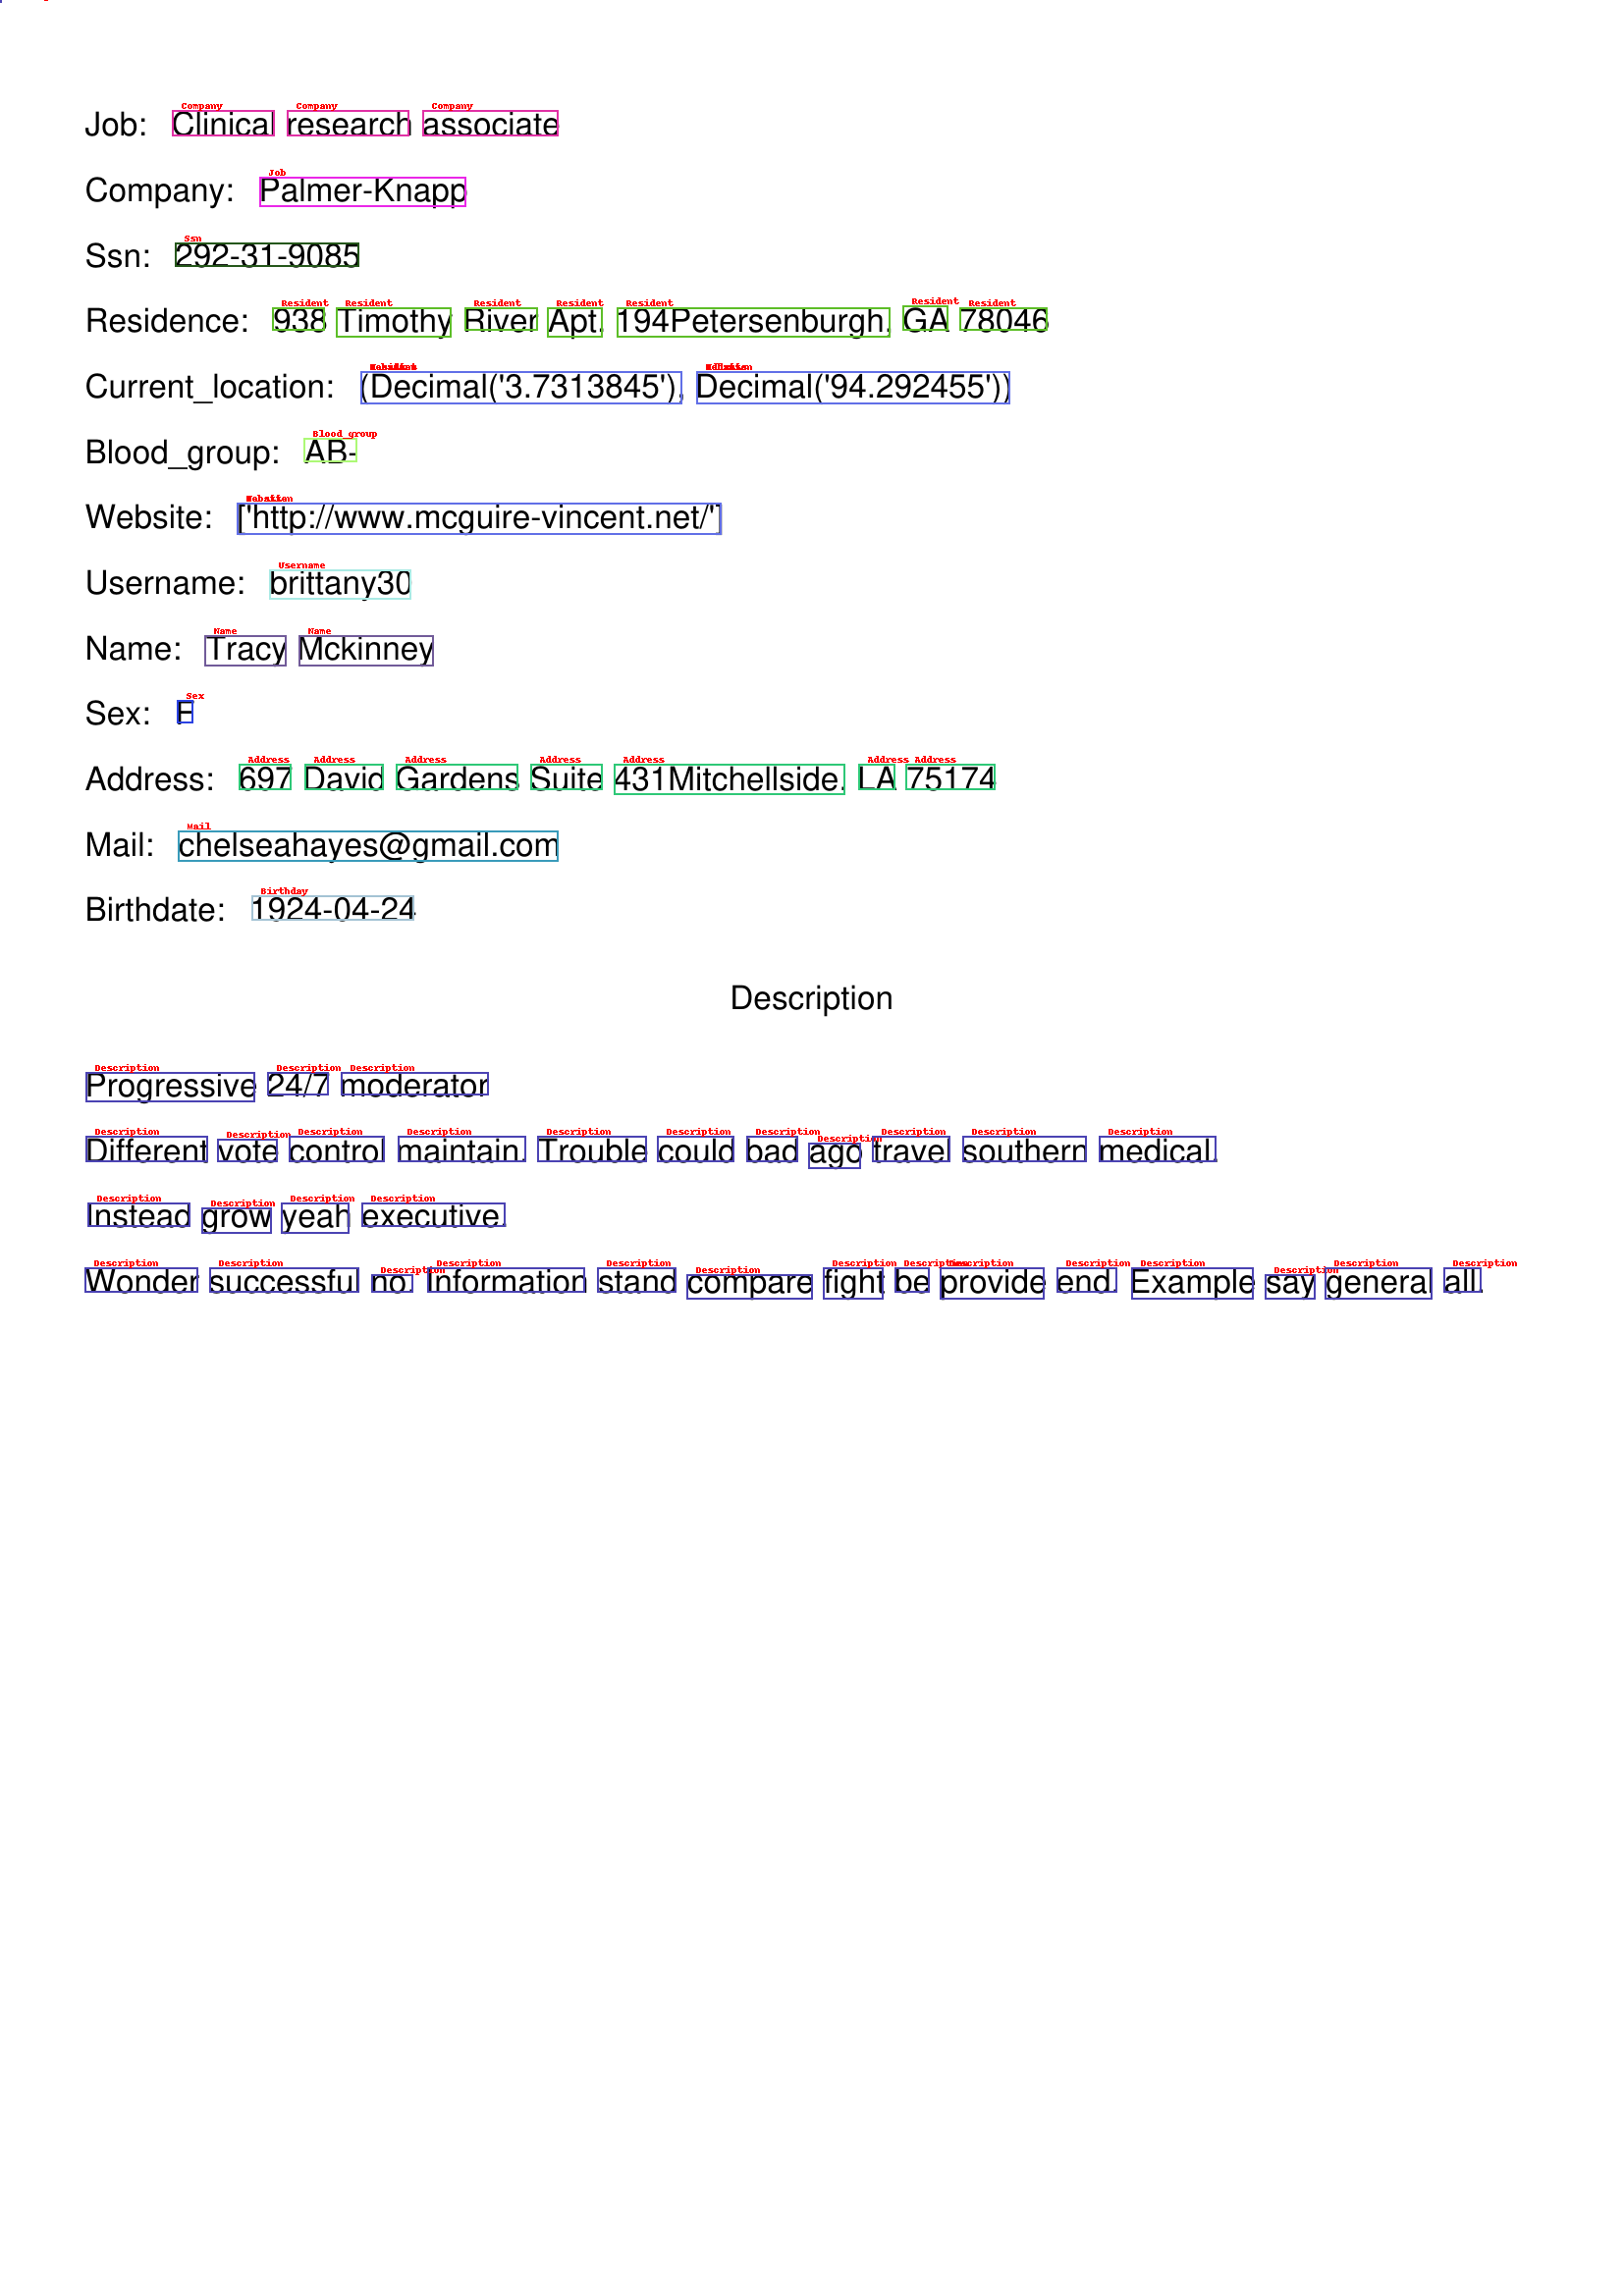

In [166]:
#Test 7
generatetest()



Address

5799 USNV RayFPO AP 77874
____________________________________________________________________________


Birthday

1946-04-27
____________________________________________________________________________


Blood_group

B-
____________________________________________________________________________


Company

Charity fundraiser
____________________________________________________________________________


Description

<s> Ergonomic web-enabled application Theory research security decade population far. Product realize mission give child consumer. Space picture newspaper space. Seven among any feel. Spring already individual race family technology form. Teach write compare.</s>
____________________________________________________________________________


Job

Mitchell Groupbb
____________________________________________________________________________


Location

(Decimal56.56 Decimal38.7083))com/
____________________________________________________________________________


M

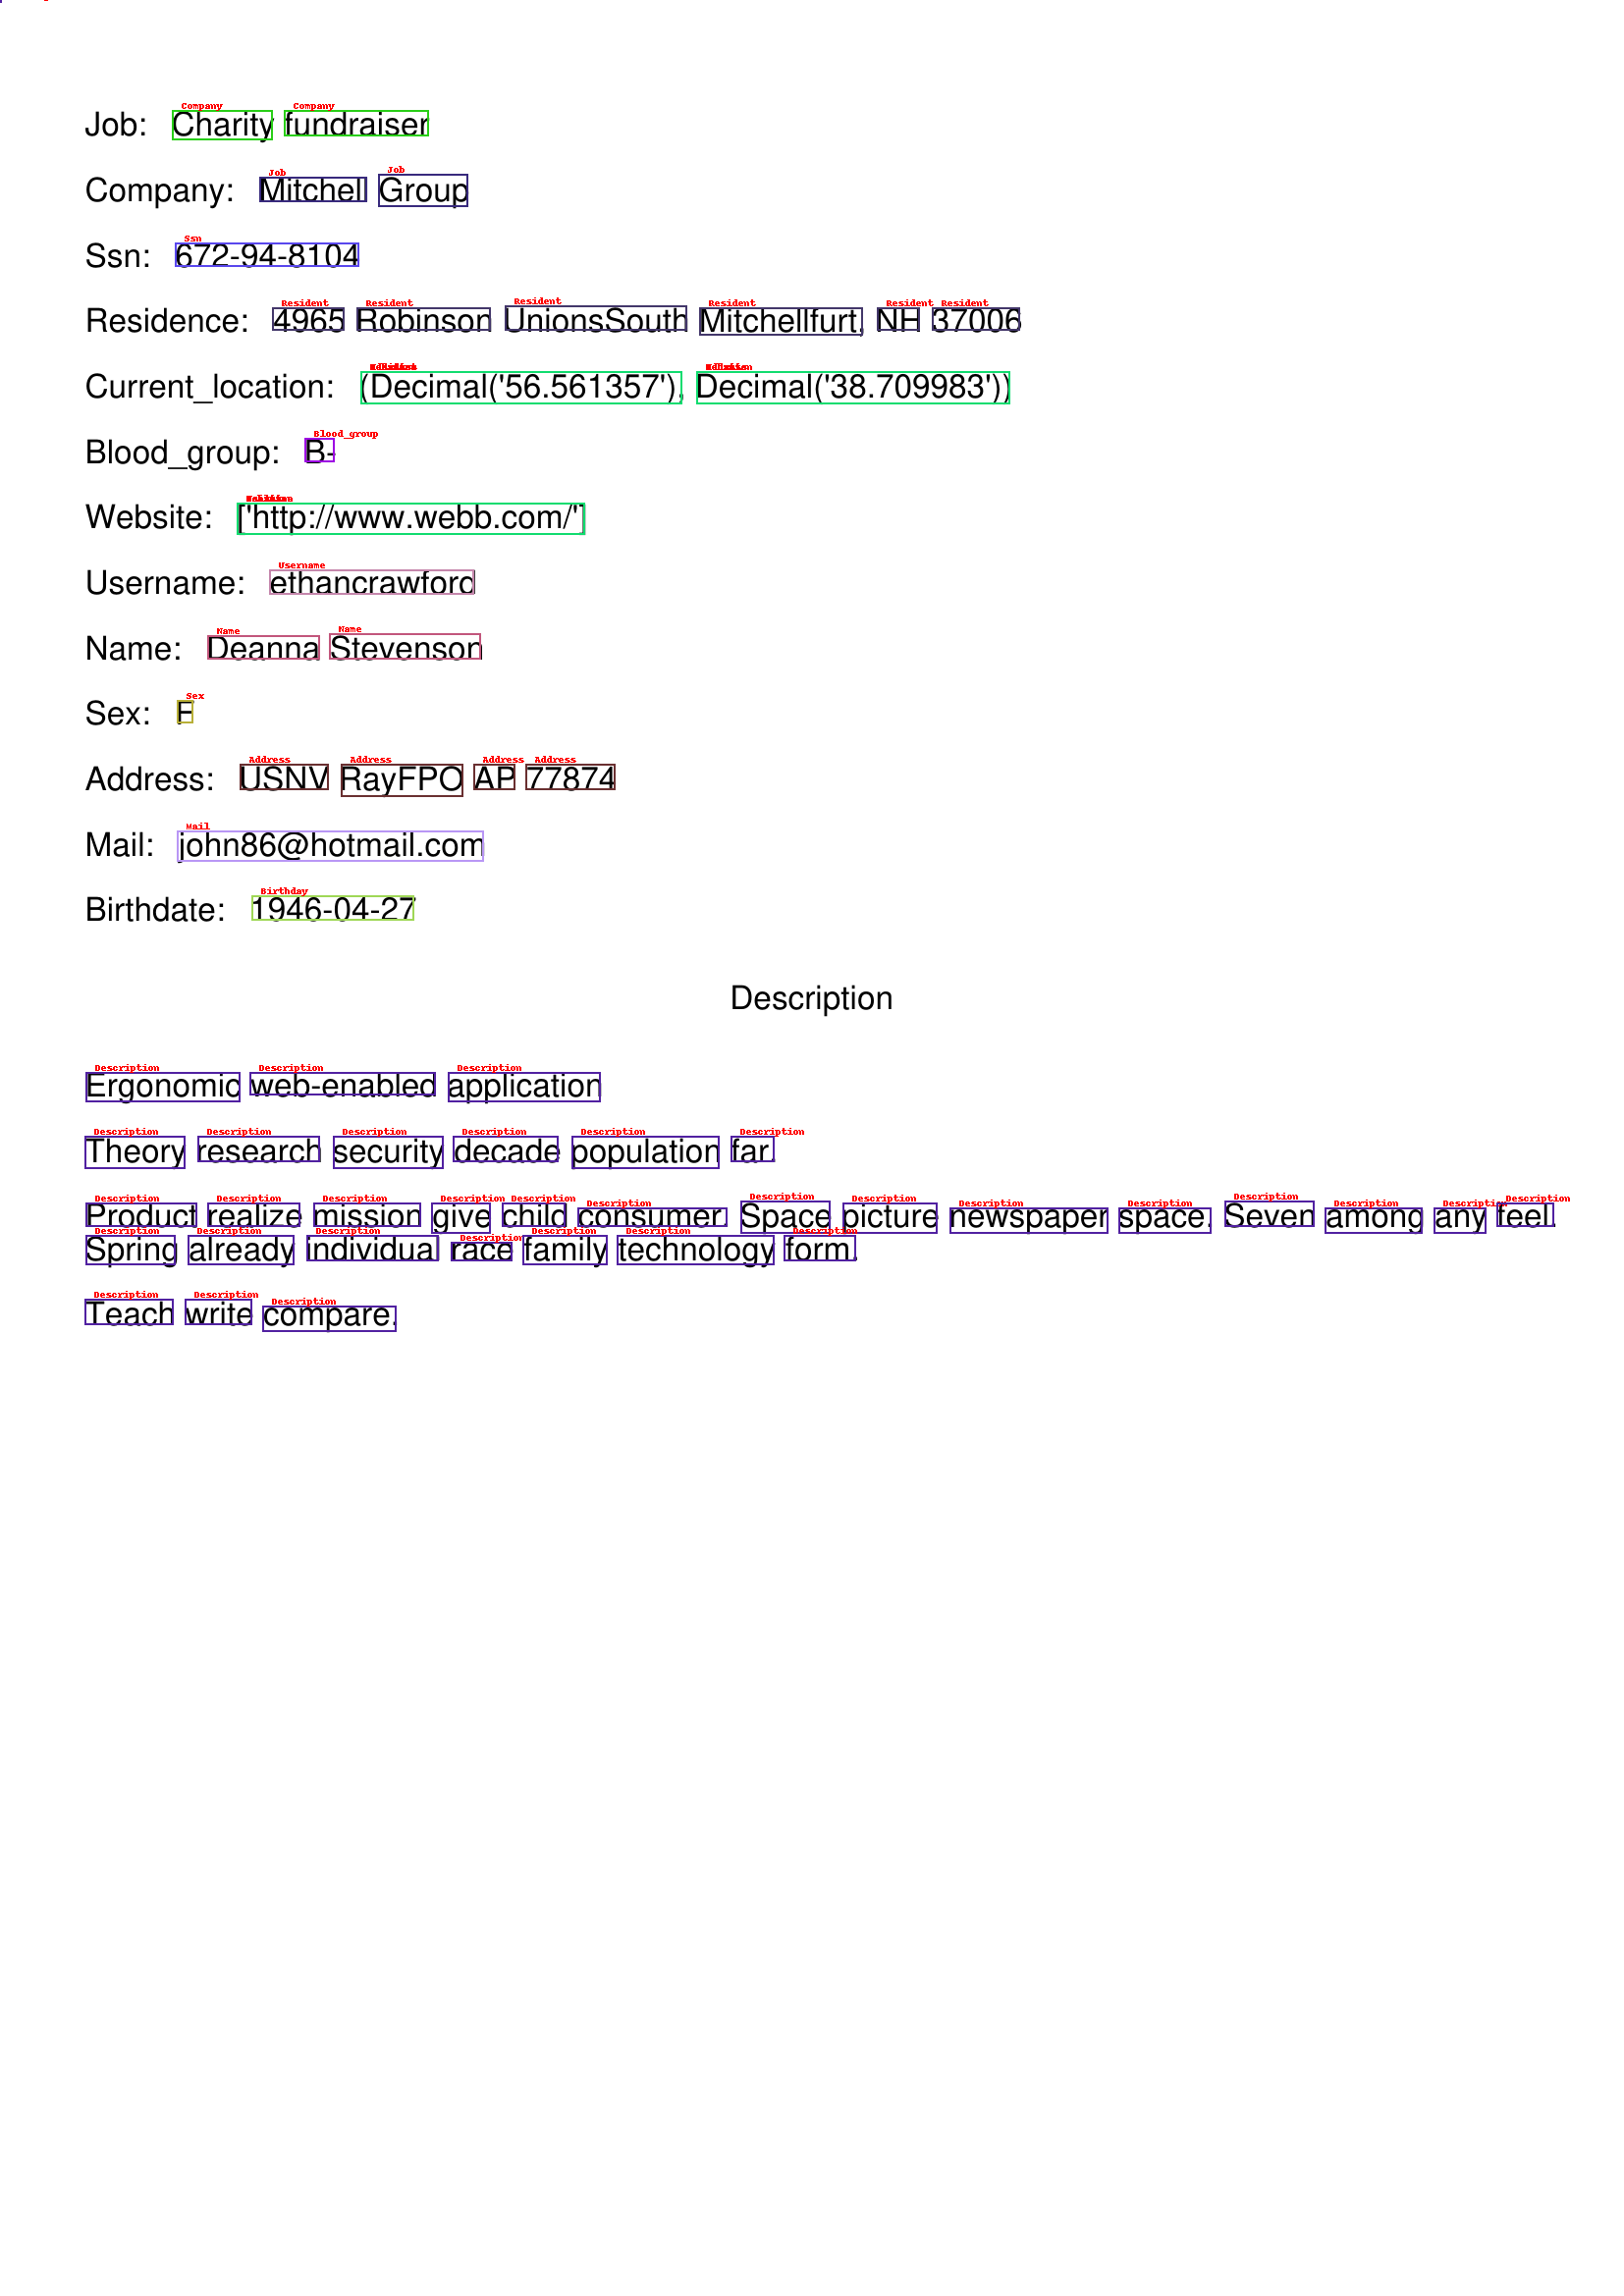

In [167]:
#Test 7
generatetest()



Address

11670 405 Colton LandWest Kristieport, WY 02100
____________________________________________________________________________


Birthday

1997-04-09
____________________________________________________________________________


Blood_group

AB+
____________________________________________________________________________


Company

Banker
____________________________________________________________________________


Description

<s> Reverse-engineered bottom-line attitude Require message also reason material wonder. Indeed plant move present difficult white. Score teacher similar message table. Ok least year special realize minute for. Heavy might off prepare mention region. Game lawyer its spend final.</s>
____________________________________________________________________________


Job

Solomon PLC-munozackhodesorg
____________________________________________________________________________


Location

(Decimal-78.9935 Decimal37.1078))httpAwww.mart.comm.com/www../
_________

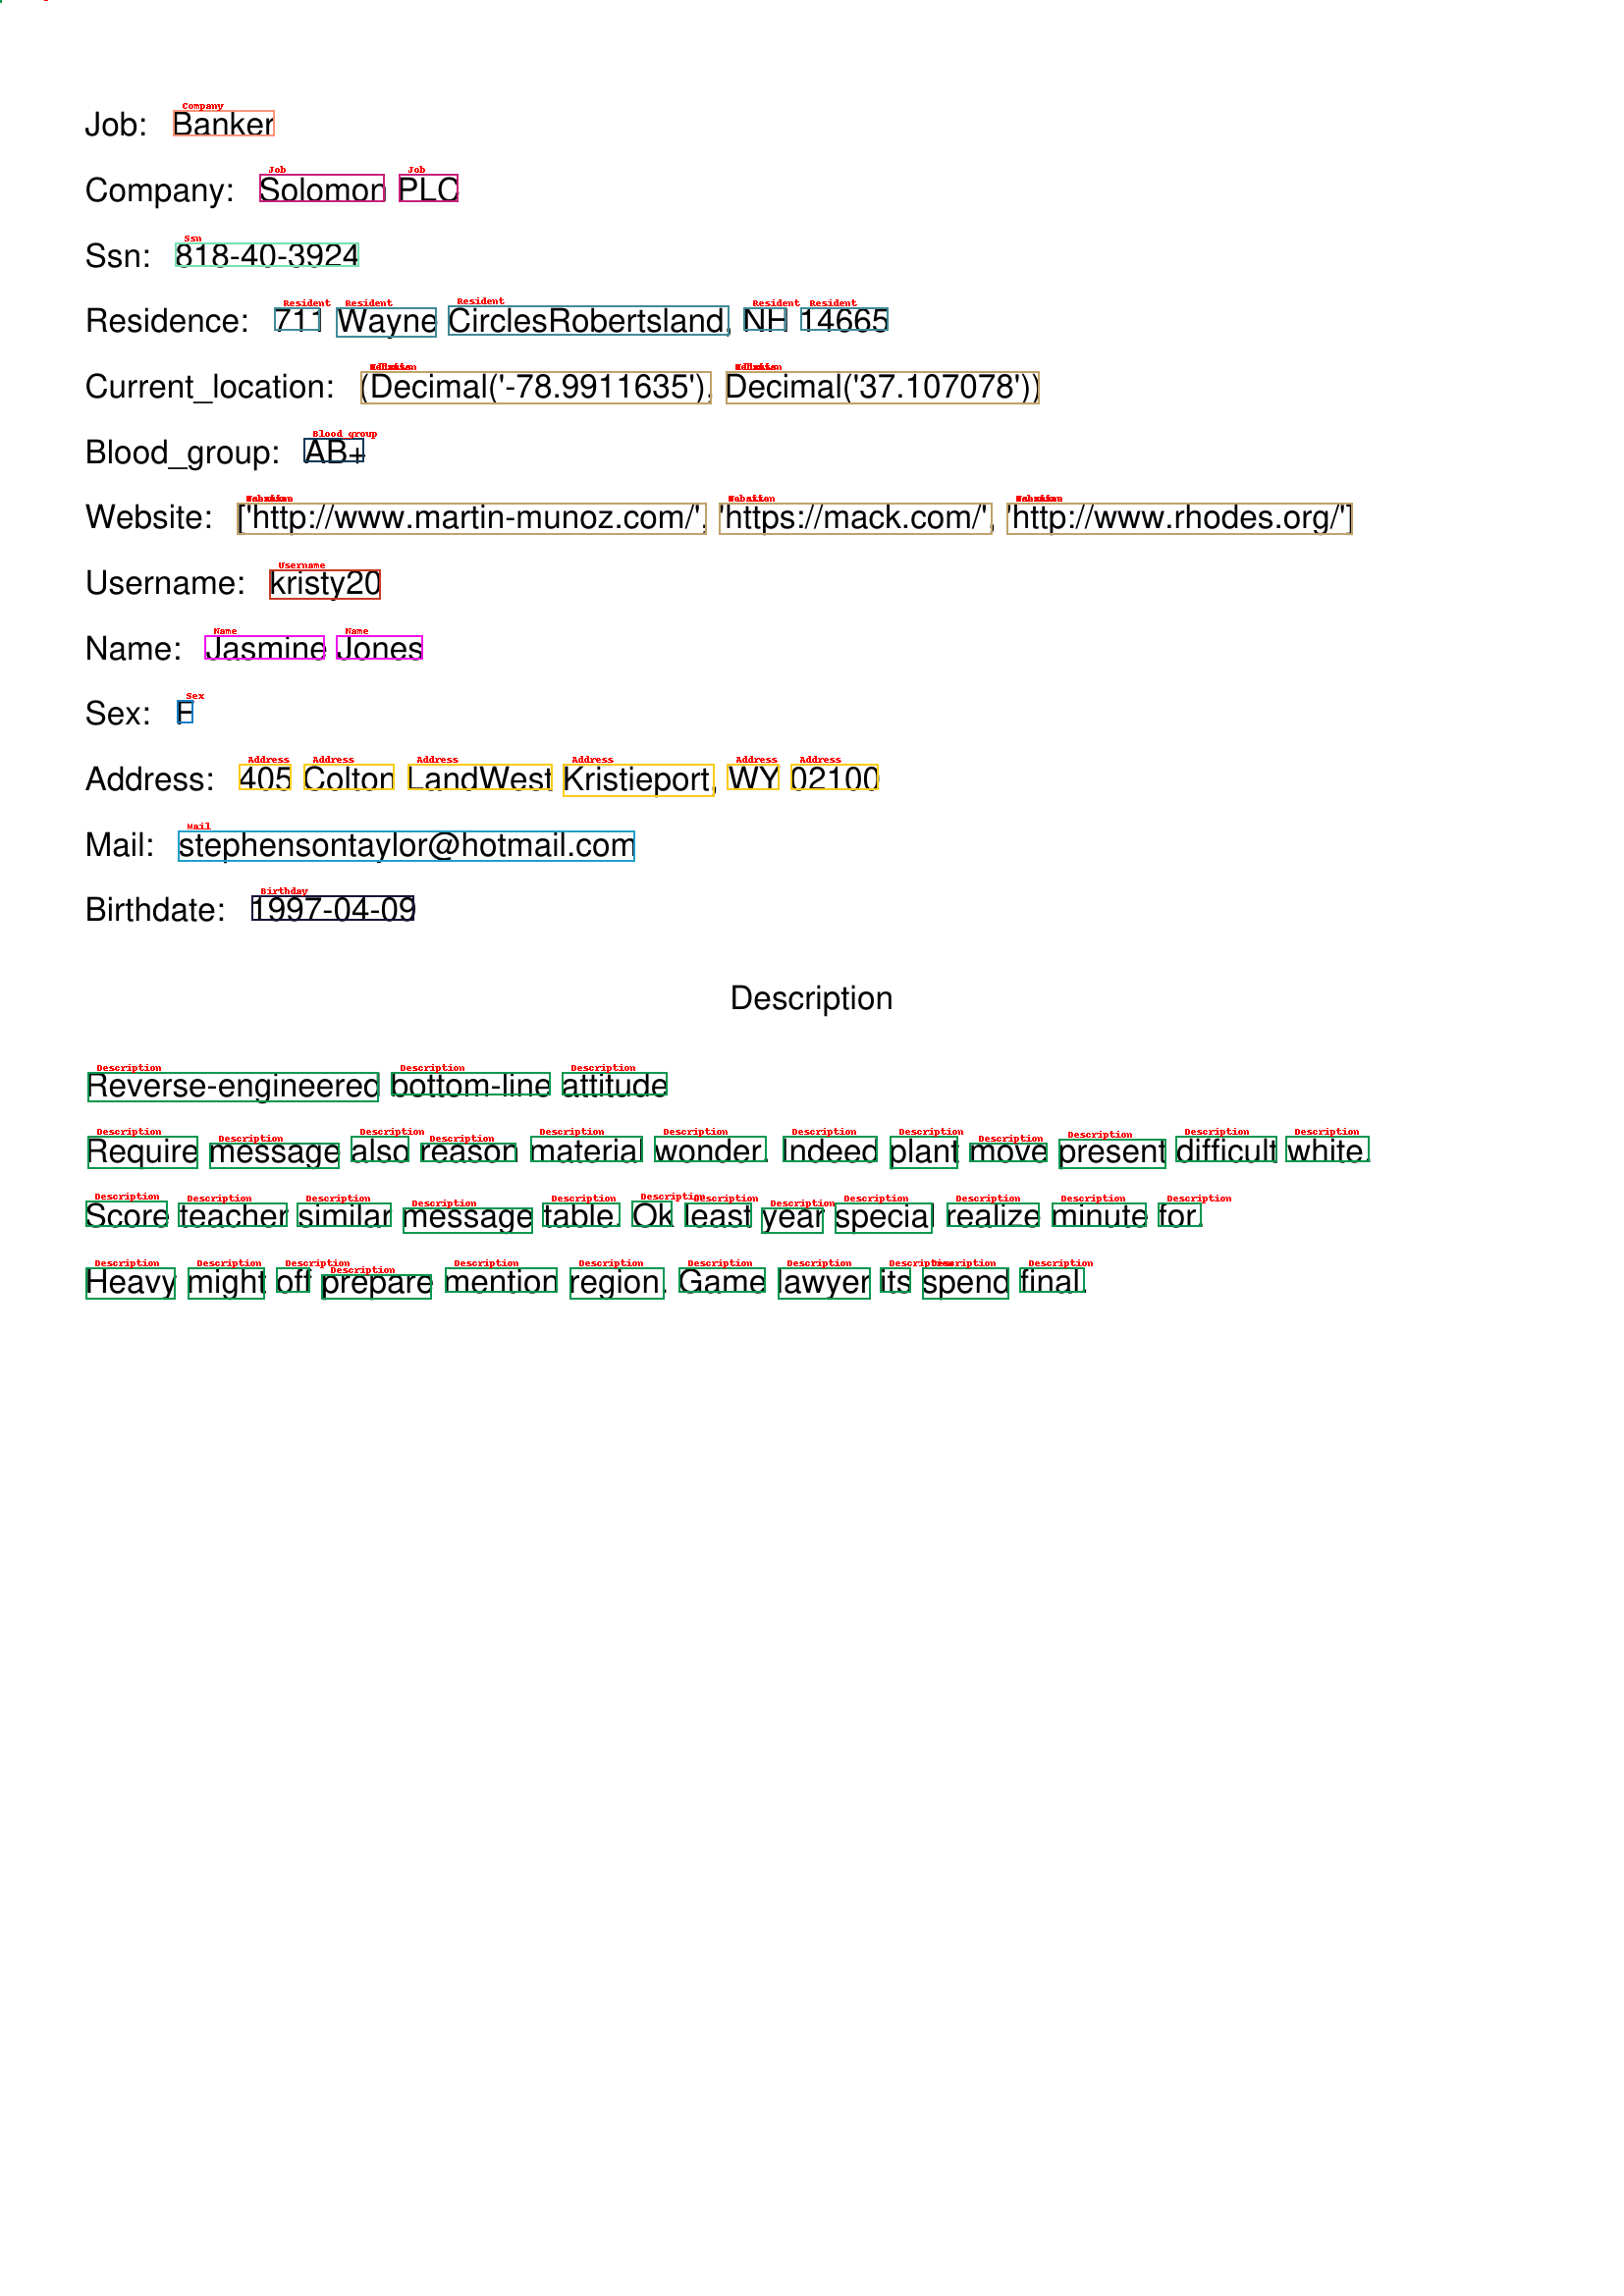

In [168]:
#Test 8
generatetest()



Address

18 9472 Alexander GreenBridgesbury, VT 90590
____________________________________________________________________________


Birthday

1948-07-15
____________________________________________________________________________


Blood_group

AB-
____________________________________________________________________________


Company

Conservator, furniture
____________________________________________________________________________


Description

<s> Exclusive client-server pricing structure Appear | she white wish serve purpose. Much federal teacher it prove again help. Compare travel price choice clear join. Professor mouth tend significant evening exist that. Remain huge why weight TV event. Ago trade many simply book. Or where from. Team center attorney hospital make people.</s>
____________________________________________________________________________


Job

Newman, Lester and Hullsoncastillo.
____________________________________________________________________________


Loc

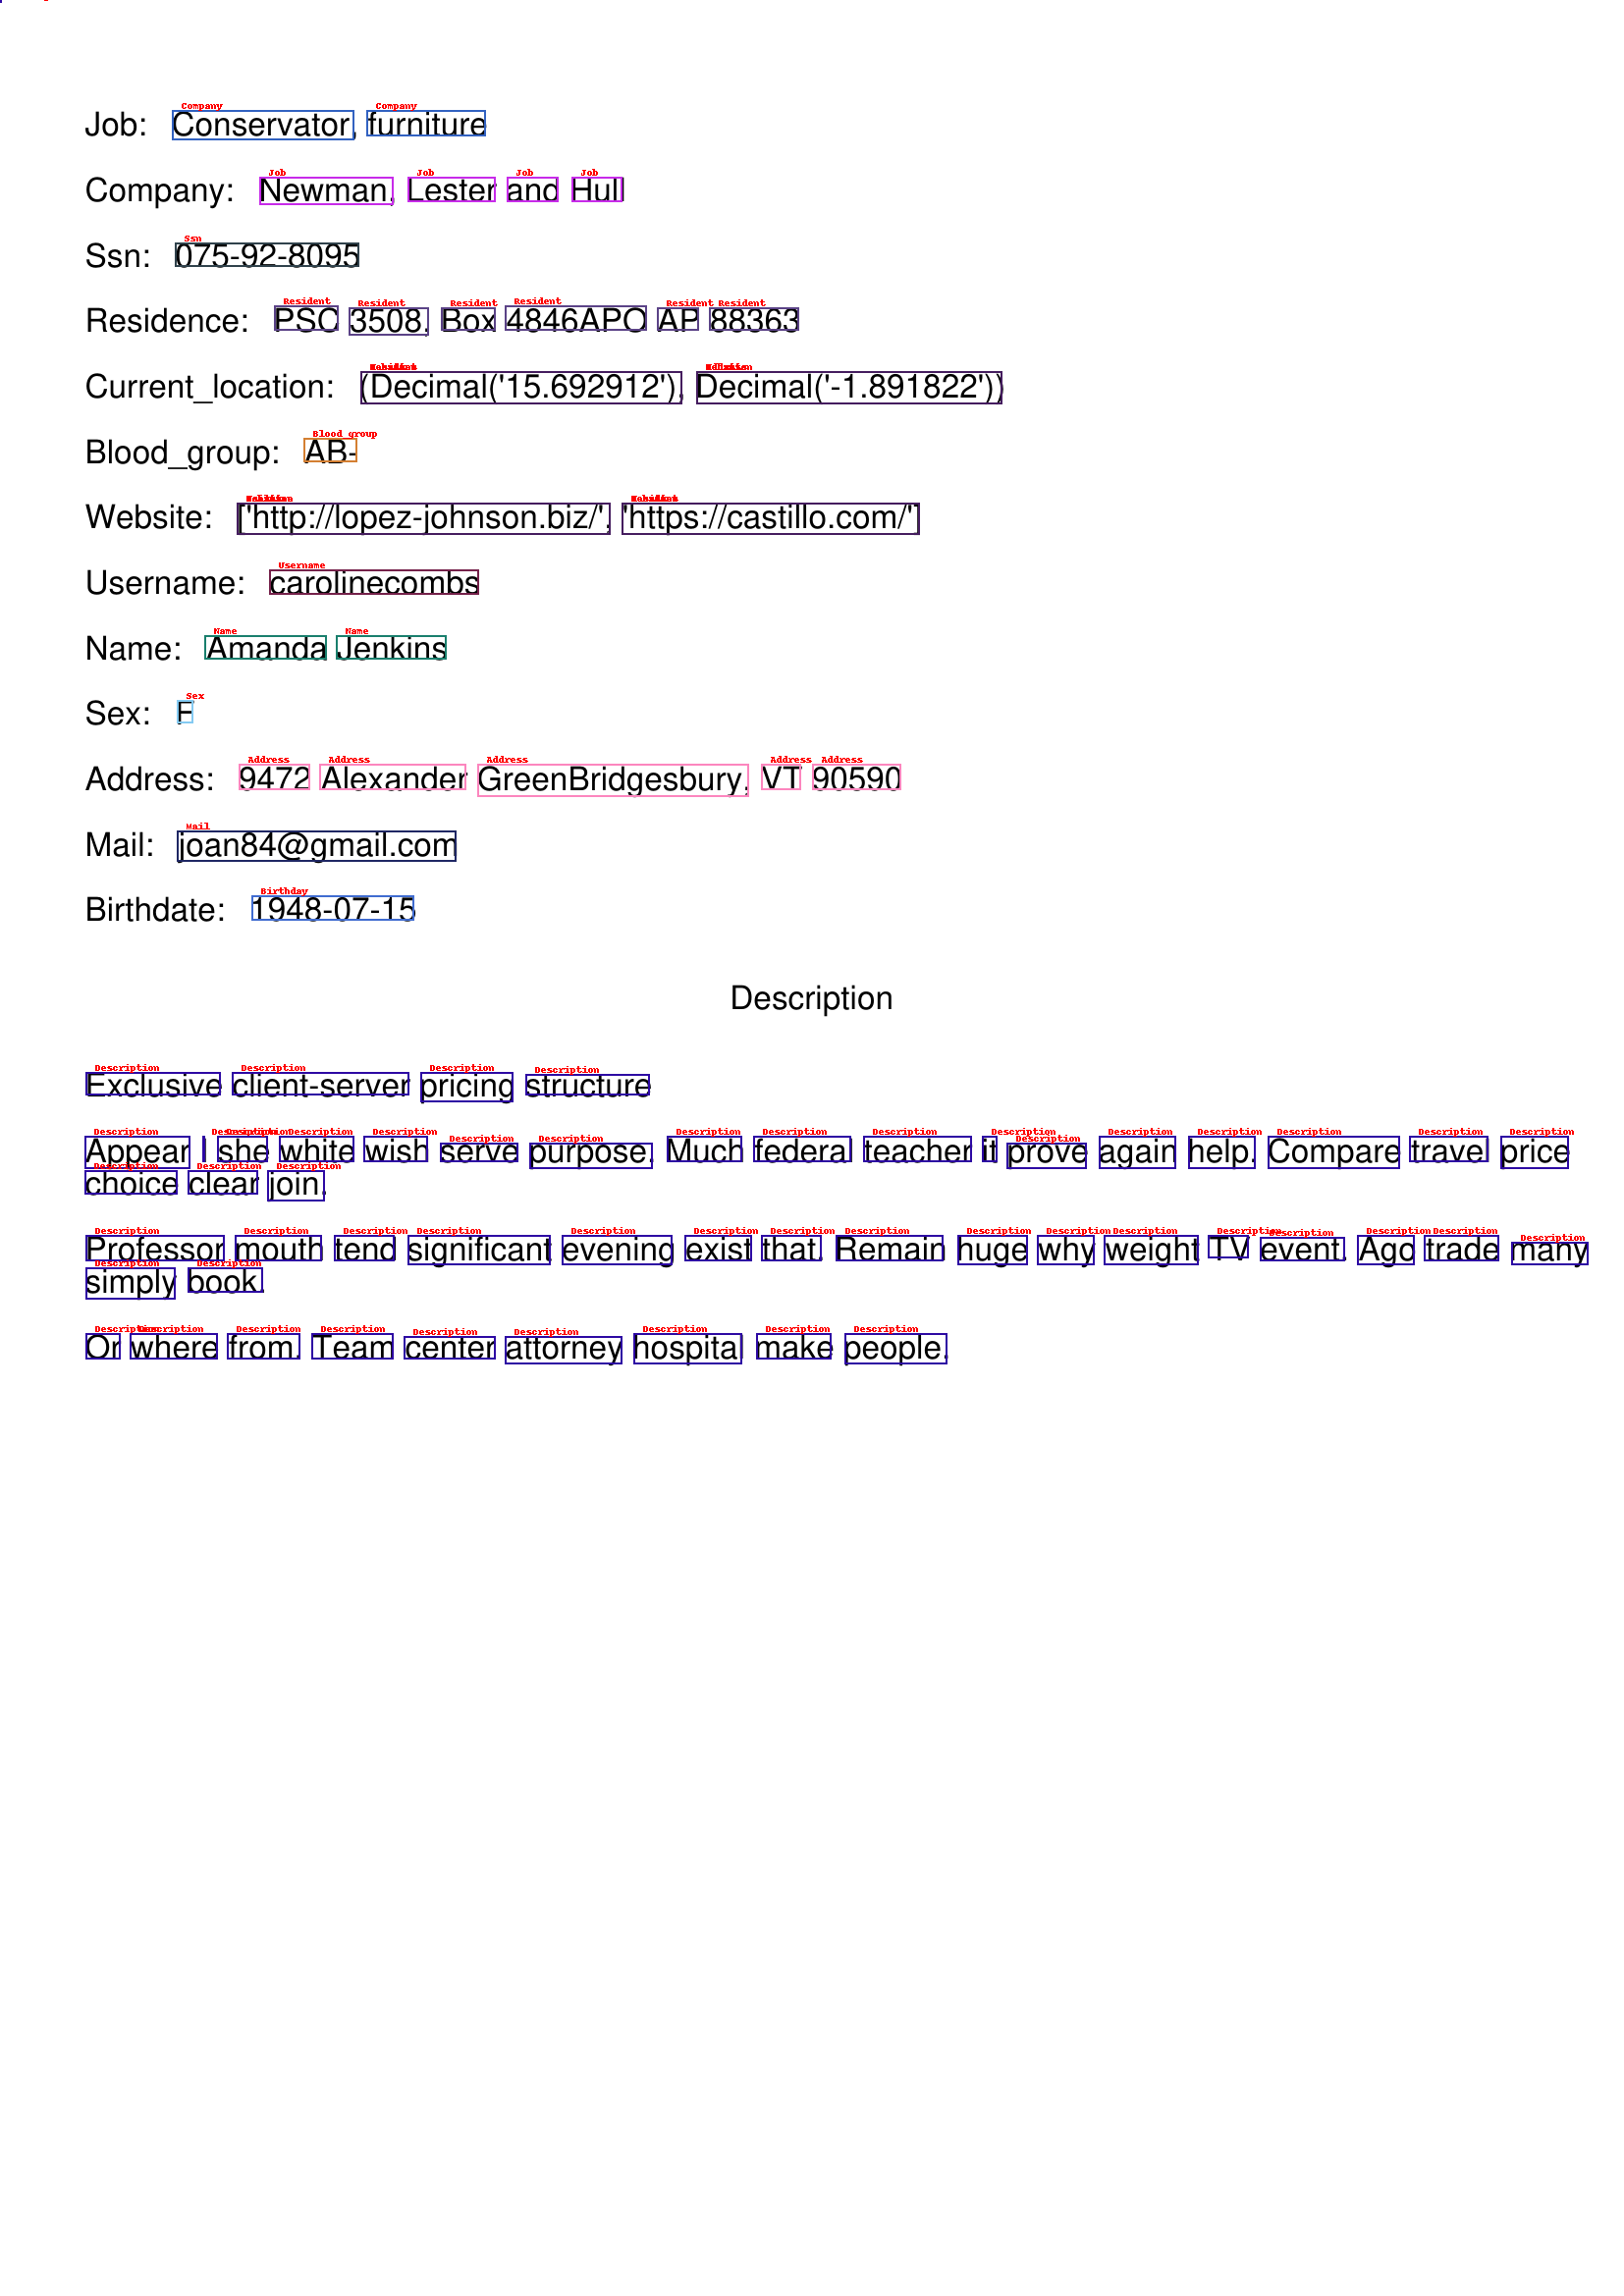

In [169]:
#Test 9
generatetest()



Address

576597 3193 Brown ShoalsHansonfort, OK 96463
____________________________________________________________________________


Birthday

2001-01-17
____________________________________________________________________________


Blood_group

B+
____________________________________________________________________________


Company

Programmer, multimedia
____________________________________________________________________________


Description

<s> Balanced user-facing challenge Which provide quite need. Ago two boy join exist. Glass what talk hospital. Later ever peace change. Class certainly each property if single civil. Special act something threat executive system street. Success nice itself media.</s>
____________________________________________________________________________


Job

Smith-Davisahan.infoarrorggerald-mosleynetandrade
____________________________________________________________________________


Location

(Decimal78.4545 Decimal25.824)):///://www.c./://f./.
__

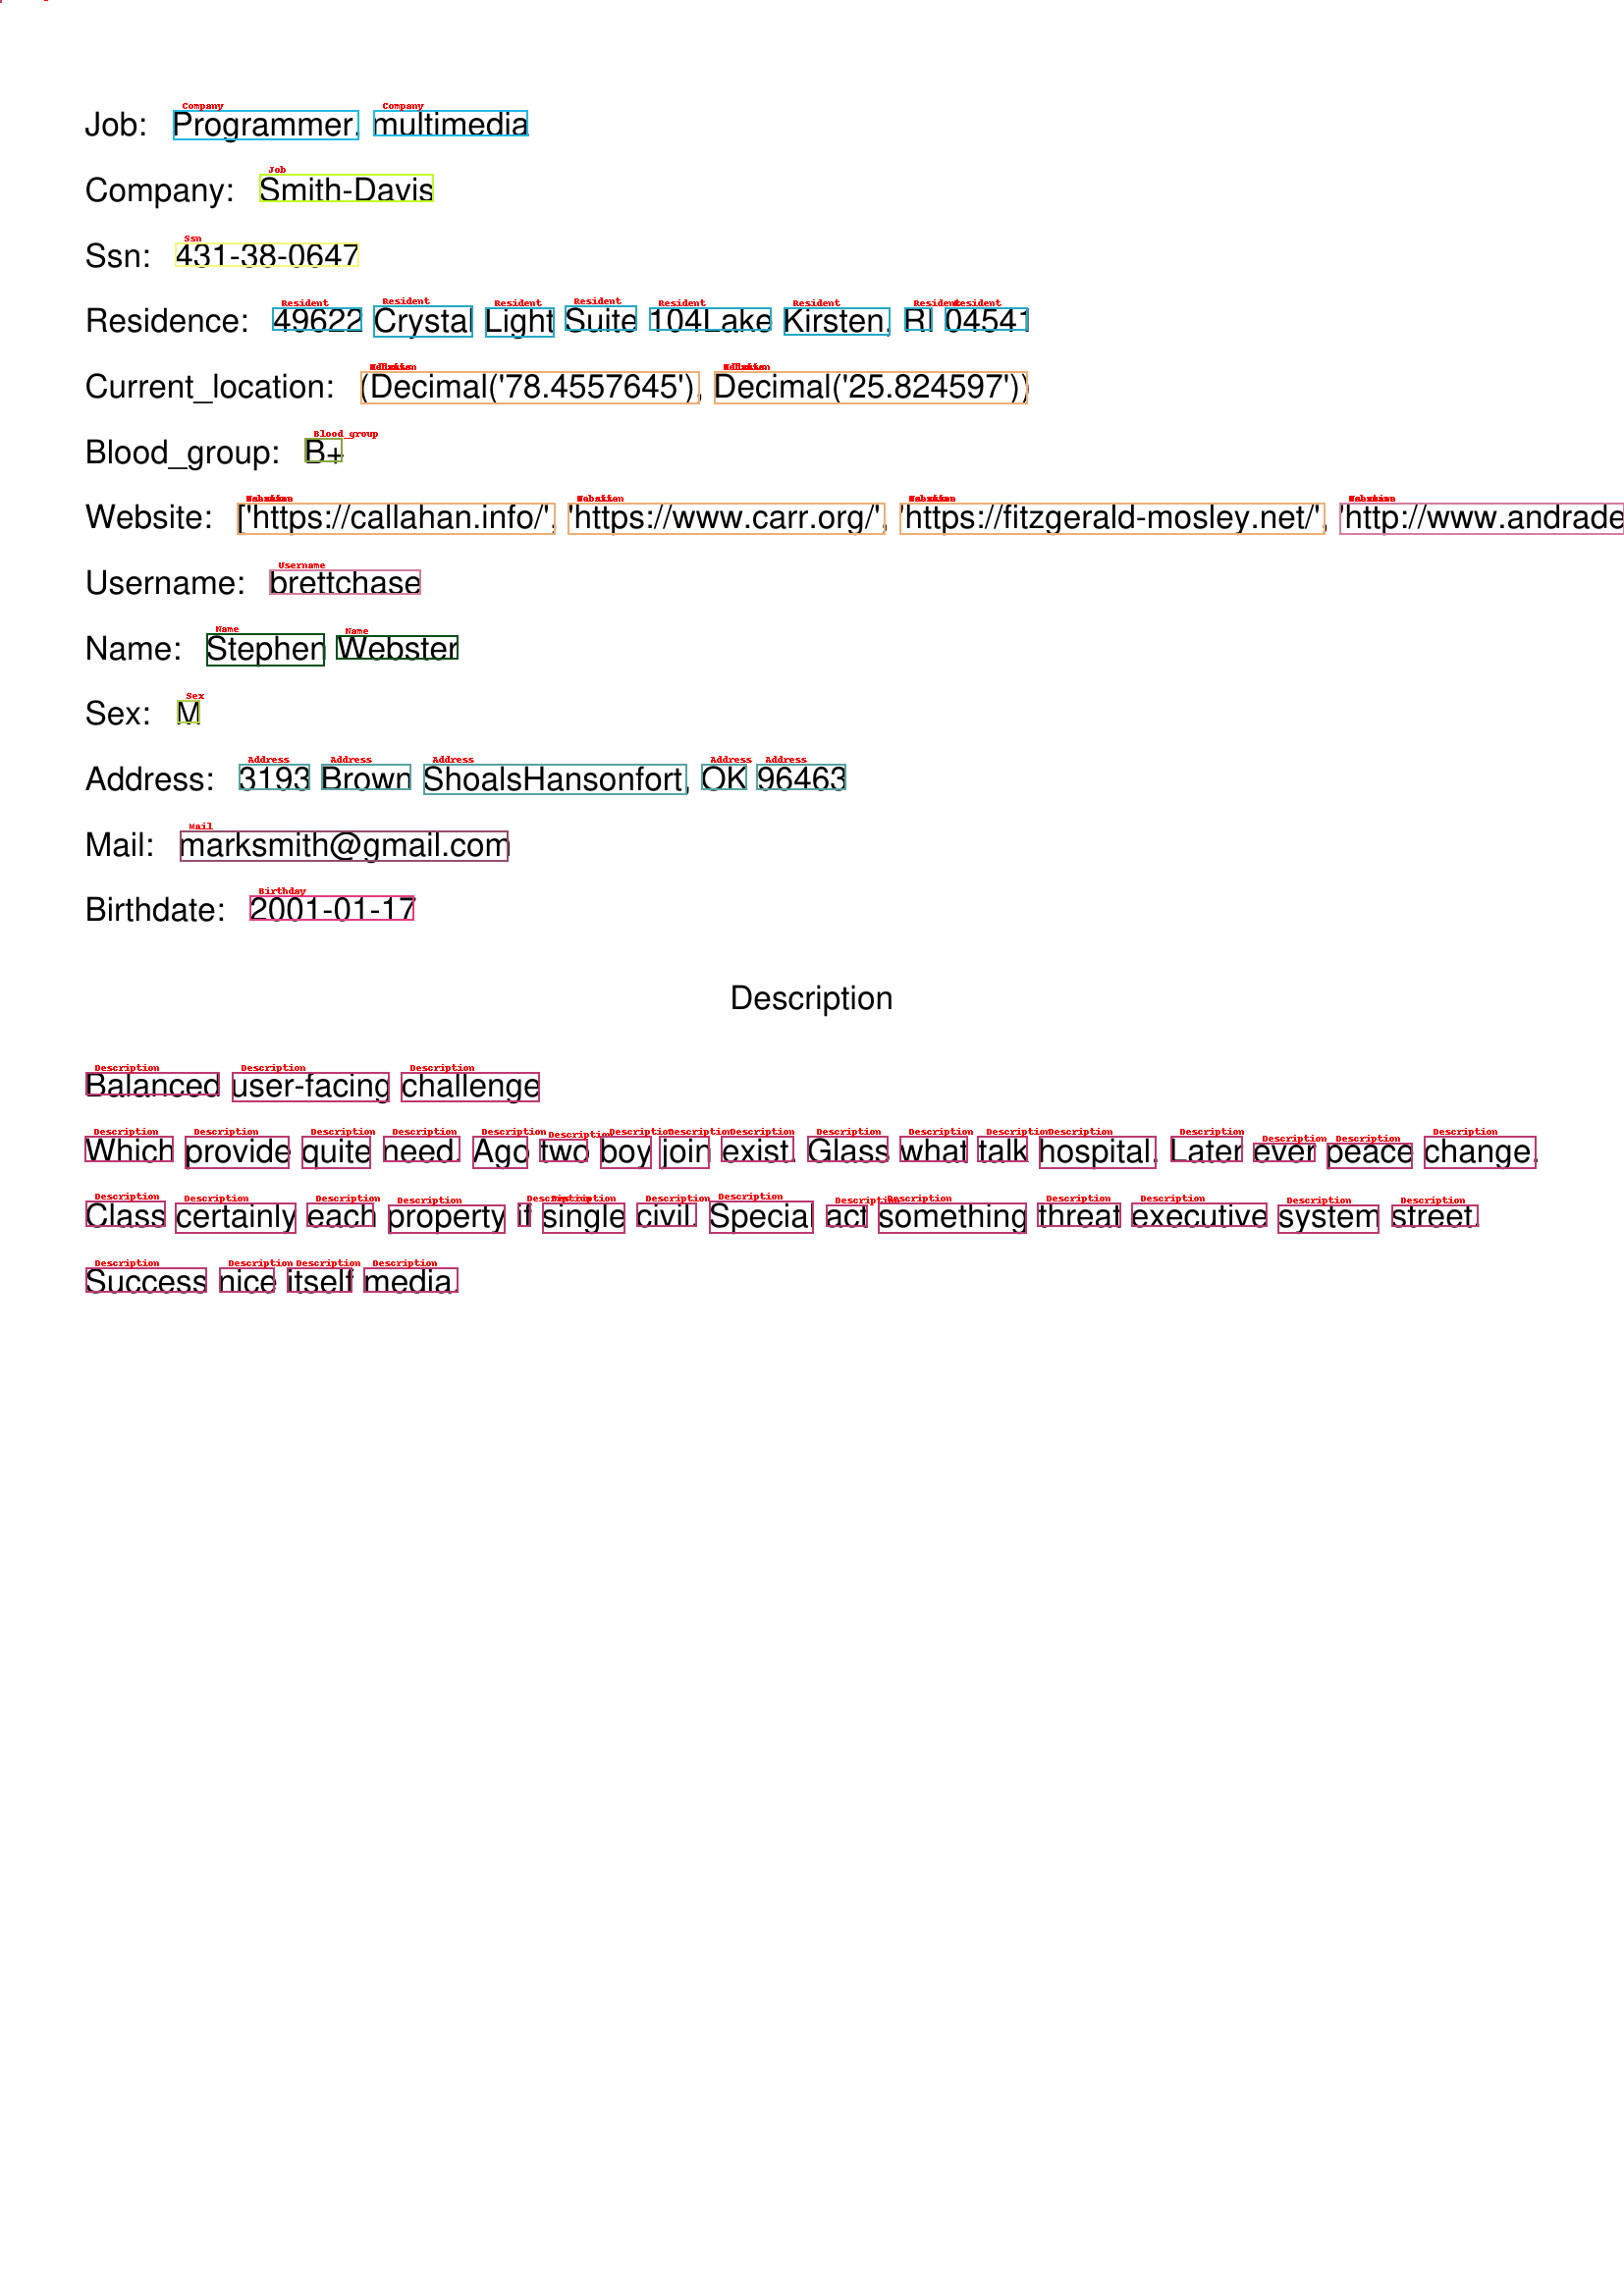

In [170]:
#Test 10
generatetest()